#Установка

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from IPython.display import Image

In [ ]:
import torch; torch.manual_seed(45)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display

# **Вариационный энкодер и декодер с CELEBA**

## 1.0 Подключение диска

In [ ]:
from pathlib import Path
from torchvision import datasets, transforms

In [ ]:
from torchvision.utils import save_image

In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # Подключим google disk

Mounted at /content/drive


In [ ]:
#!unzip -oq 'drive/MyDrive/Colab_Notebooks/SM/SM_1/100k.zip' -d 'drive/MyDrive/Colab_Notebooks/SM/SM_1' # Разархивируем zip.

In [ ]:
#   Зададим константы
# drive/MyDrive/Colab_Notebooks/SM/SM1/DataSet

MODELS_DIR = Path('Model')   # Путь для сохранения моделей
MODELS_DIR.mkdir(parents=True, exist_ok=True)   #Создадим папку по заданному пути, если её нет.
DATASET_DIR = Path('drive/MyDrive/Colab_Notebooks/SM/SM_1/DataSet')   # Путь для датасета

In [ ]:
transform_obj = transforms.Compose ([
    transforms.Resize([128,128]),
    transforms.ToTensor()
])

In [ ]:
dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform_obj)

In [ ]:
data = torch.utils.data.DataLoader(                         # Cоздание объекта `data` для загрузки данных.

        dataset,                # Указание датасета.
        batch_size=15,                                     # Указание размера данных, которые будут обрабатываться одновременно.
        shuffle=True)

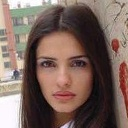

In [ ]:
img = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/DataSet/100k/000026.jpg')
img

In [ ]:
img.size

(128, 128)

## **1.1 Вариационный энкодер и декодер. Сборка и обучение.**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (128-4+2*1)/2+1=64 ).
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=2, stride=2, padding=0) # Слой свёртки. Размер карты активации( (64-2+2*0)/2+1=32 ).
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=128, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (32-4+2*1)/2+1=16 ).
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=4, padding=2) # Слой свёртки. Размер карты активации( (16-4+2*2)/4+1=5 ).

        self.linear1 = nn.Linear(256*5*5, 512)           #Скрытый внутренний слой.
        self.linear2 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.
        self.linear3 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)               # Получаем вектор(вытягиваем нашу картинку).
        x = F.relu(self.linear1(x))                     # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.

        self.mu =  self.linear2(x)                      # Присваиваем результат применения линейного слоя 2. Входная пере менная x.
        self.log_var = self.linear3(x)

        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu

        return z                                    # возврацение результата z.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.linear_b1 = nn.Linear(latent_dims, 512)
        self.linear_b2 = nn.Linear(512, 256*5*5)

        self.convTr1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=4, padding=2)
        self.convTr2 = nn.ConvTranspose2d(in_channels=128, out_channels=48, kernel_size=4, stride=2, padding=1)
        self.convTr3 = nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=2, stride=2, padding=0)
        self.convTr4 = nn.ConvTranspose2d(in_channels=24, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.linear_b1(z))            # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        z = torch.sigmoid(self.linear_b2(z))     # Выполнение прямого прохода через второй линейный слой с функцией активации сигмоид.
        z = z.reshape((-1, 256, 5, 5))         # Изменение формы в соответствии с размерами изображения 28x28.
        z = F.relu(self.convTr1(z))
        z = F.relu(self.convTr2(z))
        z = F.relu(self.convTr3(z))
        z = torch.sigmoid(self.convTr4(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):                # Собираем вариационный энкодер
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  #Вариационный энкодер
        self.decoder = Decoder(latent_dims)             # Декодер

    def forward(self, x):
        z = self.encoder(x)                             # Подаём входные данные на энкодер
        return self.decoder(z)                          # Далее на декодер и выдаём результат.

In [ ]:
print()
def train(autoencoder, data, history_loss, epochs=10):              # Создадим функцию обучения.
    opt = torch.optim.Adam(autoencoder.parameters()   )             # Оптимизатор Adam.

    for epoch in tqdm.tqdm(range(epochs)):            # Проходим по эпохам, активируем шкалу прогресса.
        t_loss = 0
        for x,y in data:
            x = x.to(device) # GPU                    # Отправляем на устройство.
            opt.zero_grad()                           # Обнуляем градиенты.
            x_hat = autoencoder(x)                    # Получим спрогназированное(восстановленное) значение.

            r_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + autoencoder.encoder.log_var - autoencoder.encoder.mu ** 2 - autoencoder.encoder.log_var.exp())
            loss = r_loss + kld_loss

            loss.backward()                           # Пройдём обратным распространением, посчитаем все градиенты.
            t_loss += loss.item()
            opt.step()                                 # Оптимизируем параметры сети.

        history_loss.append(t_loss / len(data.dataset))
        print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, t_loss / len(data.dataset)))
        print("-------------------------------------------------")

    return autoencoder, history_loss                               # Вернём результат.

In [ ]:
latent_dims = 200                                             # Выберем размерность скрытого представления (латентного пространства).
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # Создание экземпляра модели с заданной размерностью скрытого представления и
                                                              # и перенос этой модели на используемое устройство.

In [ ]:
history_loss = []
vae = VariationalAutoencoder(latent_dims).to(device)          #Создадим функцию, и перенесём её на используемое устройство.
vae_1 = train(vae, data, history_loss, epochs=100)             # Выполним обучение.

  1%|          | 1/100 [00:32<54:06, 32.79s/it]

Epoch: 0 Train mean loss: 28726.13511322
-------------------------------------------------


  2%|▏         | 2/100 [01:05<53:36, 32.82s/it]

Epoch: 1 Train mean loss: 27156.63514892
-------------------------------------------------


  3%|▎         | 3/100 [01:38<53:02, 32.81s/it]

Epoch: 2 Train mean loss: 26811.19423450
-------------------------------------------------


  4%|▍         | 4/100 [02:11<52:31, 32.83s/it]

Epoch: 3 Train mean loss: 26630.14853376
-------------------------------------------------


  5%|▌         | 5/100 [02:44<52:03, 32.88s/it]

Epoch: 4 Train mean loss: 26510.94935231
-------------------------------------------------


  6%|▌         | 6/100 [03:17<51:27, 32.85s/it]

Epoch: 5 Train mean loss: 26390.05272848
-------------------------------------------------


  7%|▋         | 7/100 [03:49<50:49, 32.79s/it]

Epoch: 6 Train mean loss: 26319.47418401
-------------------------------------------------


  8%|▊         | 8/100 [04:23<50:34, 32.98s/it]

Epoch: 7 Train mean loss: 26253.98333078
-------------------------------------------------


  9%|▉         | 9/100 [04:55<49:57, 32.94s/it]

Epoch: 8 Train mean loss: 26154.58295084
-------------------------------------------------


 10%|█         | 10/100 [05:28<49:19, 32.89s/it]

Epoch: 9 Train mean loss: 26054.43828029
-------------------------------------------------


 11%|█         | 11/100 [06:01<48:35, 32.76s/it]

Epoch: 10 Train mean loss: 25968.69072317
-------------------------------------------------


 12%|█▏        | 12/100 [06:33<47:56, 32.69s/it]

Epoch: 11 Train mean loss: 25900.49251581
-------------------------------------------------


 13%|█▎        | 13/100 [07:06<47:30, 32.76s/it]

Epoch: 12 Train mean loss: 25848.11127601
-------------------------------------------------


 14%|█▍        | 14/100 [07:39<47:04, 32.84s/it]

Epoch: 13 Train mean loss: 25799.91358119
-------------------------------------------------


 15%|█▌        | 15/100 [08:12<46:31, 32.85s/it]

Epoch: 14 Train mean loss: 25754.20116789
-------------------------------------------------


 16%|█▌        | 16/100 [08:45<45:56, 32.81s/it]

Epoch: 15 Train mean loss: 25704.95474551
-------------------------------------------------


 17%|█▋        | 17/100 [09:18<45:38, 33.00s/it]

Epoch: 16 Train mean loss: 25661.57911312
-------------------------------------------------


 18%|█▊        | 18/100 [09:51<45:13, 33.09s/it]

Epoch: 17 Train mean loss: 25620.56204865
-------------------------------------------------


 19%|█▉        | 19/100 [10:24<44:34, 33.02s/it]

Epoch: 18 Train mean loss: 25585.44027438
-------------------------------------------------


 20%|██        | 20/100 [10:58<44:08, 33.10s/it]

Epoch: 19 Train mean loss: 25545.35842513
-------------------------------------------------


 21%|██        | 21/100 [11:31<43:33, 33.08s/it]

Epoch: 20 Train mean loss: 25518.82036414
-------------------------------------------------


 22%|██▏       | 22/100 [12:03<42:50, 32.95s/it]

Epoch: 21 Train mean loss: 25486.22862352
-------------------------------------------------


 23%|██▎       | 23/100 [12:36<42:17, 32.96s/it]

Epoch: 22 Train mean loss: 25450.23396828
-------------------------------------------------


 24%|██▍       | 24/100 [13:09<41:36, 32.84s/it]

Epoch: 23 Train mean loss: 25425.57251377
-------------------------------------------------


 25%|██▌       | 25/100 [13:42<41:03, 32.84s/it]

Epoch: 24 Train mean loss: 25401.11385149
-------------------------------------------------


 26%|██▌       | 26/100 [14:14<40:26, 32.79s/it]

Epoch: 25 Train mean loss: 25370.52088178
-------------------------------------------------


 27%|██▋       | 27/100 [14:47<39:53, 32.78s/it]

Epoch: 26 Train mean loss: 25349.39138107
-------------------------------------------------


 28%|██▊       | 28/100 [15:20<39:21, 32.79s/it]

Epoch: 27 Train mean loss: 25327.37612199
-------------------------------------------------


 29%|██▉       | 29/100 [15:53<38:48, 32.79s/it]

Epoch: 28 Train mean loss: 25307.23866279
-------------------------------------------------


 30%|███       | 30/100 [16:26<38:17, 32.82s/it]

Epoch: 29 Train mean loss: 25286.81501428
-------------------------------------------------


 31%|███       | 31/100 [16:58<37:42, 32.79s/it]

Epoch: 30 Train mean loss: 25268.57706548
-------------------------------------------------


 32%|███▏      | 32/100 [17:31<37:16, 32.89s/it]

Epoch: 31 Train mean loss: 25245.32433191
-------------------------------------------------


 33%|███▎      | 33/100 [18:04<36:37, 32.80s/it]

Epoch: 32 Train mean loss: 25228.61374439
-------------------------------------------------


 34%|███▍      | 34/100 [18:38<36:23, 33.08s/it]

Epoch: 33 Train mean loss: 25211.15711444
-------------------------------------------------


 35%|███▌      | 35/100 [19:11<35:42, 32.97s/it]

Epoch: 34 Train mean loss: 25199.59243676
-------------------------------------------------


 36%|███▌      | 36/100 [19:43<35:09, 32.97s/it]

Epoch: 35 Train mean loss: 25186.06288760
-------------------------------------------------


 37%|███▋      | 37/100 [20:16<34:28, 32.84s/it]

Epoch: 36 Train mean loss: 25166.14409680
-------------------------------------------------


 38%|███▊      | 38/100 [20:48<33:48, 32.71s/it]

Epoch: 37 Train mean loss: 25154.09677938
-------------------------------------------------


 39%|███▉      | 39/100 [21:21<33:12, 32.67s/it]

Epoch: 38 Train mean loss: 25141.13900959
-------------------------------------------------


 40%|████      | 40/100 [21:54<32:41, 32.69s/it]

Epoch: 39 Train mean loss: 25132.32657844
-------------------------------------------------


 41%|████      | 41/100 [22:26<32:08, 32.69s/it]

Epoch: 40 Train mean loss: 25119.91532283
-------------------------------------------------


 42%|████▏     | 42/100 [22:59<31:36, 32.70s/it]

Epoch: 41 Train mean loss: 25105.90531926
-------------------------------------------------


 43%|████▎     | 43/100 [23:32<31:02, 32.67s/it]

Epoch: 42 Train mean loss: 25096.71376734
-------------------------------------------------


 44%|████▍     | 44/100 [24:04<30:30, 32.69s/it]

Epoch: 43 Train mean loss: 25084.82335781
-------------------------------------------------


 45%|████▌     | 45/100 [24:37<29:56, 32.67s/it]

Epoch: 44 Train mean loss: 25081.29815636
-------------------------------------------------


 46%|████▌     | 46/100 [25:11<29:41, 32.99s/it]

Epoch: 45 Train mean loss: 25065.14963025
-------------------------------------------------


 47%|████▋     | 47/100 [25:45<29:26, 33.33s/it]

Epoch: 46 Train mean loss: 25060.21514943
-------------------------------------------------


 48%|████▊     | 48/100 [26:20<29:19, 33.84s/it]

Epoch: 47 Train mean loss: 25050.95044625
-------------------------------------------------


 49%|████▉     | 49/100 [26:54<28:45, 33.83s/it]

Epoch: 48 Train mean loss: 25043.34620818
-------------------------------------------------


 50%|█████     | 50/100 [27:26<27:51, 33.43s/it]

Epoch: 49 Train mean loss: 25034.07542840
-------------------------------------------------


 51%|█████     | 51/100 [27:59<27:11, 33.30s/it]

Epoch: 50 Train mean loss: 25027.03619186
-------------------------------------------------


 52%|█████▏    | 52/100 [28:32<26:35, 33.23s/it]

Epoch: 51 Train mean loss: 25018.68696195
-------------------------------------------------


 53%|█████▎    | 53/100 [29:05<25:49, 32.97s/it]

Epoch: 52 Train mean loss: 25013.67509945
-------------------------------------------------


 54%|█████▍    | 54/100 [29:38<25:14, 32.92s/it]

Epoch: 53 Train mean loss: 25004.07282232
-------------------------------------------------


 55%|█████▌    | 55/100 [30:10<24:37, 32.82s/it]

Epoch: 54 Train mean loss: 25000.89906416
-------------------------------------------------


 56%|█████▌    | 56/100 [30:43<24:00, 32.74s/it]

Epoch: 55 Train mean loss: 24992.88768870
-------------------------------------------------


 57%|█████▋    | 57/100 [31:15<23:25, 32.69s/it]

Epoch: 56 Train mean loss: 24985.39494339
-------------------------------------------------


 58%|█████▊    | 58/100 [31:48<22:53, 32.71s/it]

Epoch: 57 Train mean loss: 24983.59618523
-------------------------------------------------


 59%|█████▉    | 59/100 [32:21<22:23, 32.76s/it]

Epoch: 58 Train mean loss: 24973.04605008
-------------------------------------------------


 60%|██████    | 60/100 [32:54<21:48, 32.72s/it]

Epoch: 59 Train mean loss: 24969.45344757
-------------------------------------------------


 61%|██████    | 61/100 [33:26<21:15, 32.71s/it]

Epoch: 60 Train mean loss: 24962.17663199
-------------------------------------------------


 62%|██████▏   | 62/100 [34:00<20:56, 33.07s/it]

Epoch: 61 Train mean loss: 24961.39424725
-------------------------------------------------


 63%|██████▎   | 63/100 [34:33<20:22, 33.05s/it]

Epoch: 62 Train mean loss: 24953.75697419
-------------------------------------------------


 64%|██████▍   | 64/100 [35:06<19:46, 32.97s/it]

Epoch: 63 Train mean loss: 24950.74766167
-------------------------------------------------


 65%|██████▌   | 65/100 [35:39<19:10, 32.88s/it]

Epoch: 64 Train mean loss: 24943.89671818
-------------------------------------------------


 66%|██████▌   | 66/100 [36:11<18:37, 32.87s/it]

Epoch: 65 Train mean loss: 24936.49089147
-------------------------------------------------


 67%|██████▋   | 67/100 [36:44<18:04, 32.87s/it]

Epoch: 66 Train mean loss: 24934.51941809
-------------------------------------------------


 68%|██████▊   | 68/100 [37:17<17:31, 32.85s/it]

Epoch: 67 Train mean loss: 24927.33672226
-------------------------------------------------


 69%|██████▉   | 69/100 [37:50<16:57, 32.83s/it]

Epoch: 68 Train mean loss: 24924.49342105
-------------------------------------------------


 70%|███████   | 70/100 [38:23<16:27, 32.92s/it]

Epoch: 69 Train mean loss: 24921.96559058
-------------------------------------------------


 71%|███████   | 71/100 [38:56<15:53, 32.90s/it]

Epoch: 70 Train mean loss: 24915.63471797
-------------------------------------------------


 72%|███████▏  | 72/100 [39:29<15:20, 32.87s/it]

Epoch: 71 Train mean loss: 24910.14957160
-------------------------------------------------


 73%|███████▎  | 73/100 [40:01<14:45, 32.81s/it]

Epoch: 72 Train mean loss: 24907.10662740
-------------------------------------------------


 74%|███████▍  | 74/100 [40:34<14:14, 32.87s/it]

Epoch: 73 Train mean loss: 24908.69924521
-------------------------------------------------


 75%|███████▌  | 75/100 [41:07<13:40, 32.83s/it]

Epoch: 74 Train mean loss: 24898.66907385
-------------------------------------------------


 76%|███████▌  | 76/100 [41:40<13:09, 32.90s/it]

Epoch: 75 Train mean loss: 24893.29156467
-------------------------------------------------


 77%|███████▋  | 77/100 [42:13<12:36, 32.88s/it]

Epoch: 76 Train mean loss: 24896.97915902
-------------------------------------------------


 78%|███████▊  | 78/100 [42:46<12:03, 32.87s/it]

Epoch: 77 Train mean loss: 24888.39135302
-------------------------------------------------


 79%|███████▉  | 79/100 [43:19<11:30, 32.90s/it]

Epoch: 78 Train mean loss: 24884.74565993
-------------------------------------------------


 80%|████████  | 80/100 [43:52<10:59, 32.98s/it]

Epoch: 79 Train mean loss: 24883.38833894
-------------------------------------------------


 81%|████████  | 81/100 [44:25<10:25, 32.94s/it]

Epoch: 80 Train mean loss: 24879.72158558
-------------------------------------------------


 82%|████████▏ | 82/100 [44:58<09:51, 32.88s/it]

Epoch: 81 Train mean loss: 24877.25572215
-------------------------------------------------


 83%|████████▎ | 83/100 [45:30<09:17, 32.80s/it]

Epoch: 82 Train mean loss: 24868.28162230
-------------------------------------------------


 84%|████████▍ | 84/100 [46:03<08:43, 32.73s/it]

Epoch: 83 Train mean loss: 24870.37814922
-------------------------------------------------


 85%|████████▌ | 85/100 [46:36<08:12, 32.82s/it]

Epoch: 84 Train mean loss: 24868.46738831
-------------------------------------------------


 86%|████████▌ | 86/100 [47:09<07:39, 32.84s/it]

Epoch: 85 Train mean loss: 24866.51107456
-------------------------------------------------


 87%|████████▋ | 87/100 [47:41<07:06, 32.80s/it]

Epoch: 86 Train mean loss: 24859.53396828
-------------------------------------------------


 88%|████████▊ | 88/100 [48:14<06:33, 32.79s/it]

Epoch: 87 Train mean loss: 24855.65288913
-------------------------------------------------


 89%|████████▉ | 89/100 [48:48<06:02, 32.99s/it]

Epoch: 88 Train mean loss: 24852.68387648
-------------------------------------------------


 90%|█████████ | 90/100 [49:20<05:28, 32.90s/it]

Epoch: 89 Train mean loss: 24851.86129131
-------------------------------------------------


 91%|█████████ | 91/100 [49:54<04:58, 33.18s/it]

Epoch: 90 Train mean loss: 24850.31105926
-------------------------------------------------


 92%|█████████▏| 92/100 [50:27<04:24, 33.05s/it]

Epoch: 91 Train mean loss: 24843.23082415
-------------------------------------------------


 93%|█████████▎| 93/100 [51:00<03:50, 32.95s/it]

Epoch: 92 Train mean loss: 24847.78895859
-------------------------------------------------


 94%|█████████▍| 94/100 [51:32<03:16, 32.83s/it]

Epoch: 93 Train mean loss: 24839.01948949
-------------------------------------------------


 95%|█████████▌| 95/100 [52:05<02:43, 32.76s/it]

Epoch: 94 Train mean loss: 24834.14468074
-------------------------------------------------


 96%|█████████▌| 96/100 [52:37<02:10, 32.72s/it]

Epoch: 95 Train mean loss: 24839.48690075
-------------------------------------------------


 97%|█████████▋| 97/100 [53:10<01:38, 32.68s/it]

Epoch: 96 Train mean loss: 24832.81196450
-------------------------------------------------


 98%|█████████▊| 98/100 [53:43<01:05, 32.71s/it]

Epoch: 97 Train mean loss: 24828.03709710
-------------------------------------------------


 99%|█████████▉| 99/100 [54:15<00:32, 32.65s/it]

Epoch: 98 Train mean loss: 24824.63177785
-------------------------------------------------


100%|██████████| 100/100 [54:48<00:00, 32.88s/it]

Epoch: 99 Train mean loss: 24820.62614749
-------------------------------------------------


In [ ]:
weights_1 = autoencoder.state_dict()                          #Веса модели.
#weights_1

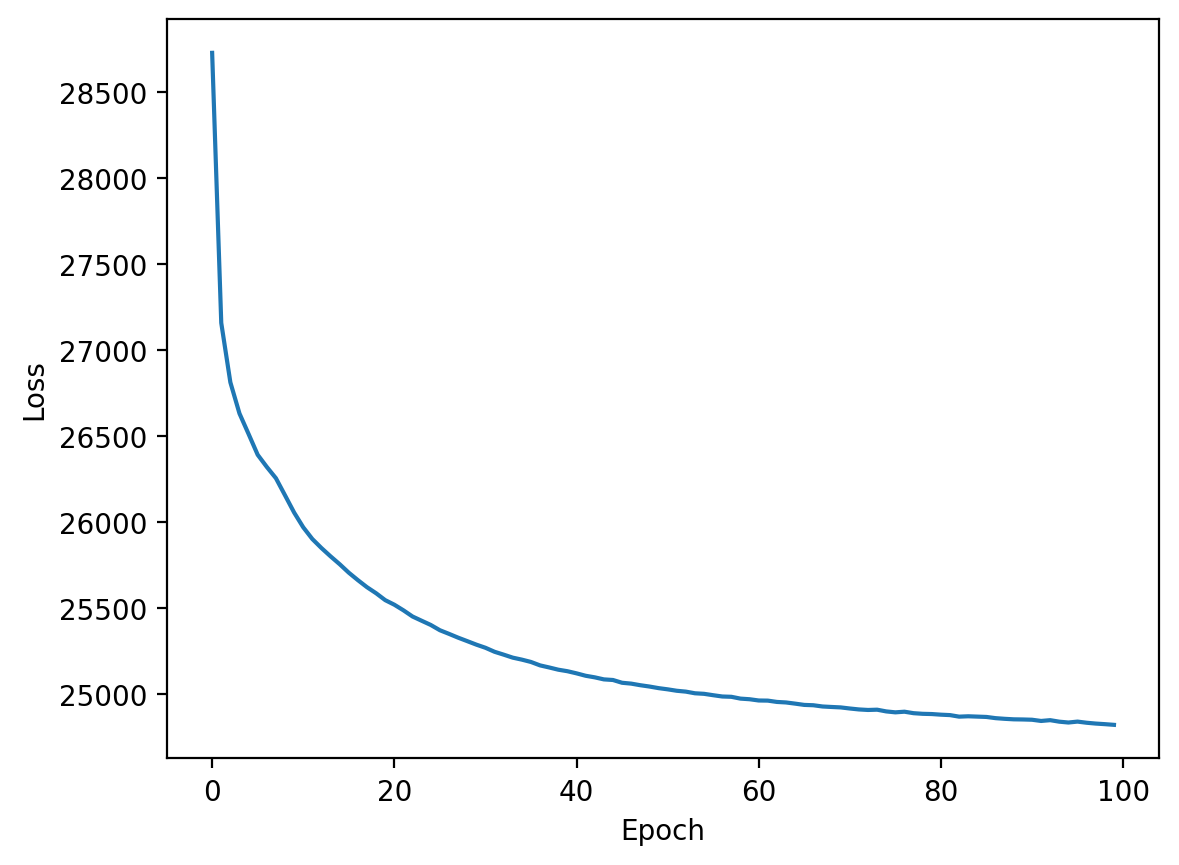

In [ ]:
# График Loss
plt.plot(history_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.manual_seed(45)         #зафиксируем рандом
x_rand = (torch.rand(10,200)*512).to(device)
x_rand.size()

torch.Size([10, 200])

In [ ]:

for i in range(x_rand.size(0)):
  x_r = x_rand[i]  # Извлекаем одну строку тензора
  pict_hat = vae.decoder(x_r).to(device)  # Получим изображение
  save_image(pict_hat.view(3, 128, 128), 'drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№1'+ '_эксперимент_'+ str(i) + '.jpg')  # Сохраним изображение

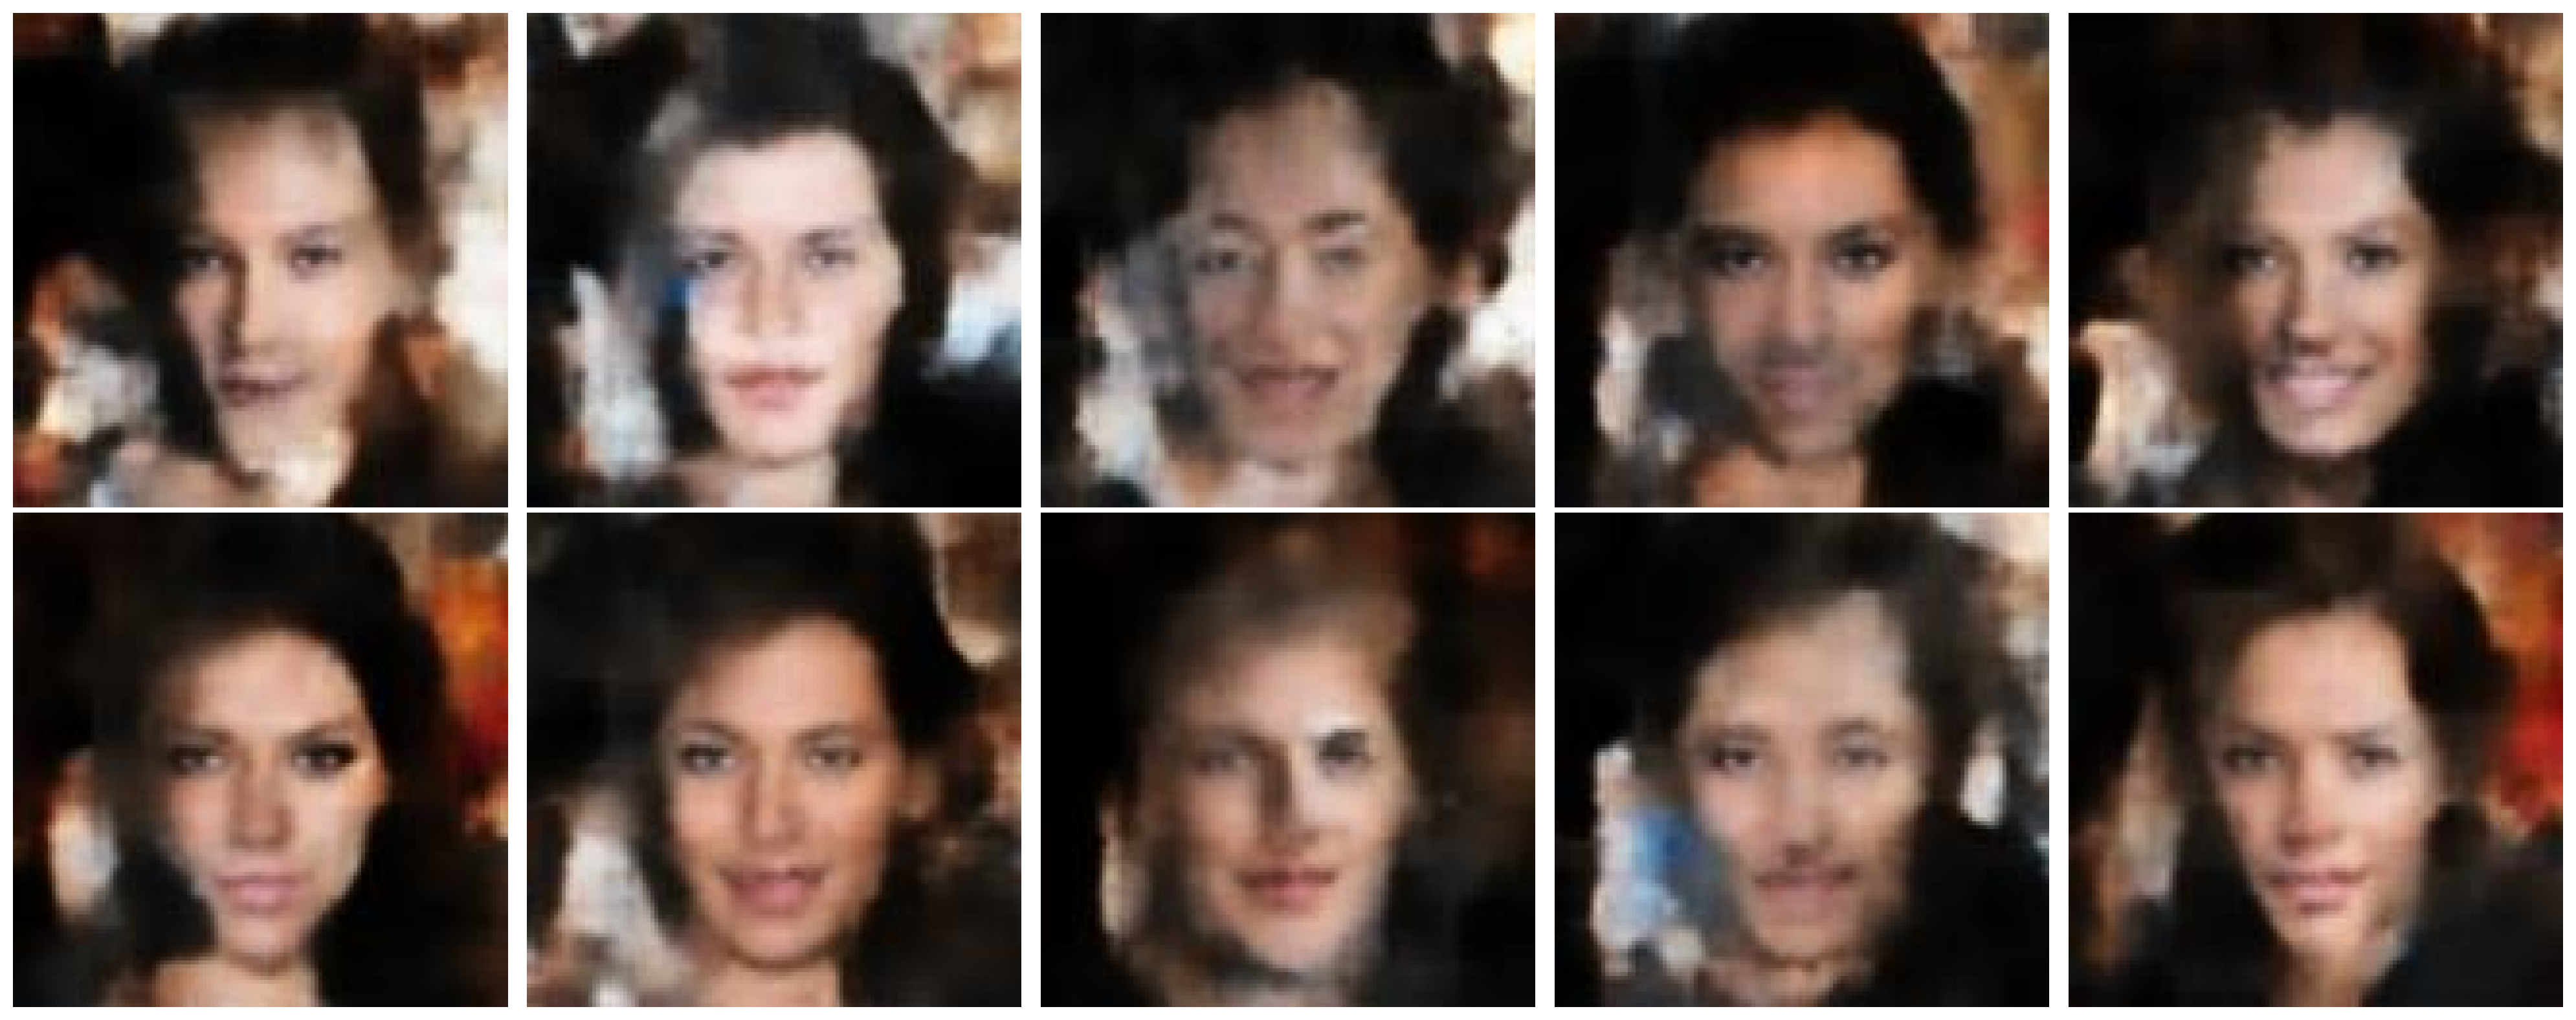

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(10):
  img_1 = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№1'+ '_эксперимент_'+ str(i) + '.jpg')
  axs[i//5, i%5].imshow(img_1)
  axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vae_1, 'drive/MyDrive/Colab_Notebooks/SM/SM_1/Model/model1.pt')

## **1.2 Вариационный энкодер и декодер. Сборка и обучение. Добавил 2 нелинейных слоя.**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (128-4+2*1)/2+1=64 ).
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=2, stride=2, padding=0) # Слой свёртки. Размер карты активации( (64-2+2*0)/2+1=32 ).
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=128, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (32-4+2*1)/2+1=16 ).
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=4, padding=2) # Слой свёртки. Размер карты активации( (16-4+2*2)/4+1=5 ).

        self.linear1 = nn.Linear(256*5*5, 512)           #Скрытый внутренний слой.
        self.linear1_1 = nn.Linear(512,512)
        self.linear1_2 = nn.Linear(512,512)

        self.linear2 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.
        self.linear3 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)               # Получаем вектор(вытягиваем нашу картинку).
        x = F.relu(self.linear1(x))                     # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        x = F.relu(self.linear1_1(x))                   # Добавим 2 нелинейных слоя.
        x = F.relu(self.linear1_2(x))

        self.mu =  self.linear2(x)                      # Присваиваем результат применения линейного слоя 2. Входная пере менная x.
        self.log_var = self.linear3(x)

        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu

        return z                                    # возврацение результата z.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()



        self.linear_b1 = nn.Linear(latent_dims, 512)

        self.linear_b2_1 = nn.Linear(512,512)
        self.linear_b2_2 = nn.Linear(512,512)
        self.linear_b2 = nn.Linear(512, 256*5*5)

        self.convTr1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=4, padding=2)
        self.convTr2 = nn.ConvTranspose2d(in_channels=128, out_channels=48, kernel_size=4, stride=2, padding=1)
        self.convTr3 = nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=2, stride=2, padding=0)
        self.convTr4 = nn.ConvTranspose2d(in_channels=24, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.linear_b1(z))            # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        z = F.relu(self.linear_b2_1(z))
        z = F.relu(self.linear_b2_2(z))
        z = torch.sigmoid(self.linear_b2(z))     # Выполнение прямого прохода через второй линейный слой с функцией активации сигмоид.
        z = z.reshape((-1, 256, 5, 5))         # Изменение формы в соответствии с размерами изображения 28x28.
        z = F.relu(self.convTr1(z))
        z = F.relu(self.convTr2(z))
        z = F.relu(self.convTr3(z))
        z = torch.sigmoid(self.convTr4(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):                # Собираем вариационный энкодер
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  #Вариационный энкодер
        self.decoder = Decoder(latent_dims)             # Декодер

    def forward(self, x):
        z = self.encoder(x)                             # Подаём входные данные на энкодер
        return self.decoder(z)                          # Далее на декодер и выдаём результат.

In [ ]:
print()
def train(autoencoder, data, history_loss, epochs=10):              # Создадим функцию обучения.
    opt = torch.optim.Adam(autoencoder.parameters()   )             # Оптимизатор Adam.

    for epoch in tqdm.tqdm(range(epochs)):            # Проходим по эпохам, активируем шкалу прогресса.
        t_loss = 0
        for x,y in data:
            x = x.to(device) # GPU                    # Отправляем на устройство.
            opt.zero_grad()                           # Обнуляем градиенты.
            x_hat = autoencoder(x)                    # Получим спрогназированное(восстановленное) значение.

            r_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + autoencoder.encoder.log_var - autoencoder.encoder.mu ** 2 - autoencoder.encoder.log_var.exp())
            loss = r_loss + kld_loss

            loss.backward()                           # Пройдём обратным распространением, посчитаем все градиенты.
            t_loss += loss.item()
            opt.step()                                 # Оптимизируем параметры сети.

        history_loss.append(t_loss / len(data.dataset))
        print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, t_loss / len(data.dataset)))
        print("-------------------------------------------------")

    return autoencoder, history_loss                               # Вернём результат.

In [ ]:
latent_dims = 200                                             # Выберем размерность скрытого представления (латентного пространства).
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # Создание экземпляра модели с заданной размерностью скрытого представления и
                                                              # и перенос этой модели на используемое устройство.

In [ ]:
history_loss = []
vae = VariationalAutoencoder(latent_dims).to(device)          #Создадим функцию, и перенесём её на используемое устройство.
vae_3 = train(vae, data, history_loss, epochs=100)             # Выполним обучение.

  1%|          | 1/100 [00:33<54:51, 33.25s/it]

Epoch: 0 Train mean loss: 30384.23456752
-------------------------------------------------


  2%|▏         | 2/100 [01:07<55:06, 33.74s/it]

Epoch: 1 Train mean loss: 29267.03619186
-------------------------------------------------


  3%|▎         | 3/100 [01:40<54:00, 33.41s/it]

Epoch: 2 Train mean loss: 28457.06337464
-------------------------------------------------


  4%|▍         | 4/100 [02:13<53:17, 33.30s/it]

Epoch: 3 Train mean loss: 28135.64814871
-------------------------------------------------


  5%|▌         | 5/100 [02:46<52:39, 33.26s/it]

Epoch: 4 Train mean loss: 28060.18005151
-------------------------------------------------


  6%|▌         | 6/100 [03:19<51:59, 33.18s/it]

Epoch: 5 Train mean loss: 28005.15667330
-------------------------------------------------


  7%|▋         | 7/100 [03:52<51:21, 33.14s/it]

Epoch: 6 Train mean loss: 27862.74308191
-------------------------------------------------


  8%|▊         | 8/100 [04:25<50:45, 33.11s/it]

Epoch: 7 Train mean loss: 27755.26725061
-------------------------------------------------


  9%|▉         | 9/100 [04:59<50:23, 33.22s/it]

Epoch: 8 Train mean loss: 27702.12853937
-------------------------------------------------


 10%|█         | 10/100 [05:32<49:41, 33.13s/it]

Epoch: 9 Train mean loss: 27654.79541514
-------------------------------------------------


 11%|█         | 11/100 [06:05<49:04, 33.09s/it]

Epoch: 10 Train mean loss: 27531.84611893
-------------------------------------------------


 12%|█▏        | 12/100 [06:38<48:31, 33.09s/it]

Epoch: 11 Train mean loss: 27442.07501275
-------------------------------------------------


 13%|█▎        | 13/100 [07:11<48:00, 33.11s/it]

Epoch: 12 Train mean loss: 27390.79623368
-------------------------------------------------


 14%|█▍        | 14/100 [07:44<47:28, 33.12s/it]

Epoch: 13 Train mean loss: 27365.85182579
-------------------------------------------------


 15%|█▌        | 15/100 [08:17<46:52, 33.09s/it]

Epoch: 14 Train mean loss: 27336.26033252
-------------------------------------------------


 16%|█▌        | 16/100 [08:51<46:28, 33.20s/it]

Epoch: 15 Train mean loss: 27314.15654070
-------------------------------------------------


 17%|█▋        | 17/100 [09:24<45:52, 33.16s/it]

Epoch: 16 Train mean loss: 27298.04273511
-------------------------------------------------


 18%|█▊        | 18/100 [09:57<45:17, 33.14s/it]

Epoch: 17 Train mean loss: 27269.84198286
-------------------------------------------------


 19%|█▉        | 19/100 [10:30<44:50, 33.22s/it]

Epoch: 18 Train mean loss: 27254.09085067
-------------------------------------------------


 20%|██        | 20/100 [11:03<44:14, 33.19s/it]

Epoch: 19 Train mean loss: 27239.19896471
-------------------------------------------------


 21%|██        | 21/100 [11:36<43:35, 33.11s/it]

Epoch: 20 Train mean loss: 27222.97766983
-------------------------------------------------


 22%|██▏       | 22/100 [12:09<43:05, 33.15s/it]

Epoch: 21 Train mean loss: 27205.04141932
-------------------------------------------------


 23%|██▎       | 23/100 [12:43<42:38, 33.23s/it]

Epoch: 22 Train mean loss: 27188.97184568
-------------------------------------------------


 24%|██▍       | 24/100 [13:16<42:02, 33.19s/it]

Epoch: 23 Train mean loss: 27175.18981283
-------------------------------------------------


 25%|██▌       | 25/100 [13:49<41:25, 33.14s/it]

Epoch: 24 Train mean loss: 27162.94588178
-------------------------------------------------


 26%|██▌       | 26/100 [14:22<40:54, 33.17s/it]

Epoch: 25 Train mean loss: 27149.22235057
-------------------------------------------------


 27%|██▋       | 27/100 [14:55<40:19, 33.14s/it]

Epoch: 26 Train mean loss: 27124.88976438
-------------------------------------------------


 28%|██▊       | 28/100 [15:28<39:40, 33.07s/it]

Epoch: 27 Train mean loss: 27109.19540494
-------------------------------------------------


 29%|██▉       | 29/100 [16:01<39:09, 33.09s/it]

Epoch: 28 Train mean loss: 27100.19416820
-------------------------------------------------


 30%|███       | 30/100 [16:34<38:36, 33.09s/it]

Epoch: 29 Train mean loss: 27080.87055539
-------------------------------------------------


 31%|███       | 31/100 [17:08<38:24, 33.40s/it]

Epoch: 30 Train mean loss: 27061.43785190
-------------------------------------------------


 32%|███▏      | 32/100 [17:42<37:52, 33.42s/it]

Epoch: 31 Train mean loss: 27051.17890657
-------------------------------------------------


 33%|███▎      | 33/100 [18:15<37:16, 33.39s/it]

Epoch: 32 Train mean loss: 27031.47126173
-------------------------------------------------


 34%|███▍      | 34/100 [18:48<36:38, 33.32s/it]

Epoch: 33 Train mean loss: 27014.10830528
-------------------------------------------------


 35%|███▌      | 35/100 [19:21<36:00, 33.24s/it]

Epoch: 34 Train mean loss: 26999.26533303
-------------------------------------------------


 36%|███▌      | 36/100 [19:54<35:21, 33.15s/it]

Epoch: 35 Train mean loss: 26980.29578998
-------------------------------------------------


 37%|███▋      | 37/100 [20:27<34:44, 33.09s/it]

Epoch: 36 Train mean loss: 26970.99866636
-------------------------------------------------


 38%|███▊      | 38/100 [21:01<34:14, 33.13s/it]

Epoch: 37 Train mean loss: 26952.32045849
-------------------------------------------------


 39%|███▉      | 39/100 [21:34<33:42, 33.15s/it]

Epoch: 38 Train mean loss: 26932.61971389
-------------------------------------------------


 40%|████      | 40/100 [22:07<33:06, 33.11s/it]

Epoch: 39 Train mean loss: 26921.44186557
-------------------------------------------------


 41%|████      | 41/100 [22:40<32:34, 33.13s/it]

Epoch: 40 Train mean loss: 26911.68266014
-------------------------------------------------


 42%|████▏     | 42/100 [23:14<32:08, 33.25s/it]

Epoch: 41 Train mean loss: 26888.20597970
-------------------------------------------------


 43%|████▎     | 43/100 [23:47<31:35, 33.25s/it]

Epoch: 42 Train mean loss: 26877.84123572
-------------------------------------------------


 44%|████▍     | 44/100 [24:20<31:09, 33.39s/it]

Epoch: 43 Train mean loss: 26859.36430794
-------------------------------------------------


 45%|████▌     | 45/100 [24:54<30:35, 33.38s/it]

Epoch: 44 Train mean loss: 26836.88354498
-------------------------------------------------


 46%|████▌     | 46/100 [25:27<30:02, 33.38s/it]

Epoch: 45 Train mean loss: 26827.40598735
-------------------------------------------------


 47%|████▋     | 47/100 [26:01<29:32, 33.45s/it]

Epoch: 46 Train mean loss: 26810.10508976
-------------------------------------------------


 48%|████▊     | 48/100 [26:34<28:58, 33.42s/it]

Epoch: 47 Train mean loss: 26792.32723888
-------------------------------------------------


 49%|████▉     | 49/100 [27:07<28:22, 33.38s/it]

Epoch: 48 Train mean loss: 26784.18360873
-------------------------------------------------


 50%|█████     | 50/100 [27:41<27:50, 33.40s/it]

Epoch: 49 Train mean loss: 26768.66076346
-------------------------------------------------


 51%|█████     | 51/100 [28:14<27:17, 33.43s/it]

Epoch: 50 Train mean loss: 26750.00130049
-------------------------------------------------


 52%|█████▏    | 52/100 [28:47<26:35, 33.24s/it]

Epoch: 51 Train mean loss: 26730.61038862
-------------------------------------------------


 53%|█████▎    | 53/100 [29:20<26:01, 33.22s/it]

Epoch: 52 Train mean loss: 26725.88260404
-------------------------------------------------


 54%|█████▍    | 54/100 [29:54<25:30, 33.26s/it]

Epoch: 53 Train mean loss: 26709.93769125
-------------------------------------------------


 55%|█████▌    | 55/100 [30:27<24:57, 33.28s/it]

Epoch: 54 Train mean loss: 26689.00525041
-------------------------------------------------


 56%|█████▌    | 56/100 [31:00<24:26, 33.32s/it]

Epoch: 55 Train mean loss: 26679.83479192
-------------------------------------------------


 57%|█████▋    | 57/100 [31:34<23:55, 33.39s/it]

Epoch: 56 Train mean loss: 26666.95195838
-------------------------------------------------


 58%|█████▊    | 58/100 [32:07<23:21, 33.36s/it]

Epoch: 57 Train mean loss: 26648.41503468
-------------------------------------------------


 59%|█████▉    | 59/100 [32:41<22:48, 33.38s/it]

Epoch: 58 Train mean loss: 26626.22355416
-------------------------------------------------


 60%|██████    | 60/100 [33:15<22:30, 33.75s/it]

Epoch: 59 Train mean loss: 26621.80879233
-------------------------------------------------


 61%|██████    | 61/100 [33:49<21:51, 33.62s/it]

Epoch: 60 Train mean loss: 26606.92783303
-------------------------------------------------


 62%|██████▏   | 62/100 [34:22<21:14, 33.54s/it]

Epoch: 61 Train mean loss: 26591.19996685
-------------------------------------------------


 63%|██████▎   | 63/100 [34:56<20:42, 33.58s/it]

Epoch: 62 Train mean loss: 26580.80958282
-------------------------------------------------


 64%|██████▍   | 64/100 [35:29<20:06, 33.51s/it]

Epoch: 63 Train mean loss: 26566.63914984
-------------------------------------------------


 65%|██████▌   | 65/100 [36:02<19:29, 33.41s/it]

Epoch: 64 Train mean loss: 26551.00746124
-------------------------------------------------


 66%|██████▌   | 66/100 [36:36<18:54, 33.38s/it]

Epoch: 65 Train mean loss: 26535.21953284
-------------------------------------------------


 67%|██████▋   | 67/100 [37:09<18:24, 33.47s/it]

Epoch: 66 Train mean loss: 26530.35835118
-------------------------------------------------


 68%|██████▊   | 68/100 [37:43<17:50, 33.45s/it]

Epoch: 67 Train mean loss: 26522.19092972
-------------------------------------------------


 69%|██████▉   | 69/100 [38:16<17:17, 33.48s/it]

Epoch: 68 Train mean loss: 26502.48885404
-------------------------------------------------


 70%|███████   | 70/100 [38:50<16:46, 33.54s/it]

Epoch: 69 Train mean loss: 26484.47535700
-------------------------------------------------


 71%|███████   | 71/100 [39:23<16:11, 33.49s/it]

Epoch: 70 Train mean loss: 26480.18958078
-------------------------------------------------


 72%|███████▏  | 72/100 [39:57<15:37, 33.49s/it]

Epoch: 71 Train mean loss: 26480.59891626
-------------------------------------------------


 73%|███████▎  | 73/100 [40:30<15:05, 33.53s/it]

Epoch: 72 Train mean loss: 26461.49053448
-------------------------------------------------


 74%|███████▍  | 74/100 [41:04<14:29, 33.45s/it]

Epoch: 73 Train mean loss: 26444.37810078
-------------------------------------------------


 75%|███████▌  | 75/100 [41:38<14:07, 33.88s/it]

Epoch: 74 Train mean loss: 26436.89169472
-------------------------------------------------


 76%|███████▌  | 76/100 [42:12<13:29, 33.72s/it]

Epoch: 75 Train mean loss: 26422.61153611
-------------------------------------------------


 77%|███████▋  | 77/100 [42:45<12:54, 33.66s/it]

Epoch: 76 Train mean loss: 26412.97204457
-------------------------------------------------


 78%|███████▊  | 78/100 [43:19<12:18, 33.57s/it]

Epoch: 77 Train mean loss: 26399.26069206
-------------------------------------------------


 79%|███████▉  | 79/100 [43:52<11:44, 33.53s/it]

Epoch: 78 Train mean loss: 26384.75370512
-------------------------------------------------


 80%|████████  | 80/100 [44:26<11:11, 33.55s/it]

Epoch: 79 Train mean loss: 26371.37084608
-------------------------------------------------


 81%|████████  | 81/100 [44:59<10:35, 33.45s/it]

Epoch: 80 Train mean loss: 26365.62232507
-------------------------------------------------


 82%|████████▏ | 82/100 [45:32<10:01, 33.42s/it]

Epoch: 81 Train mean loss: 26364.54848531
-------------------------------------------------


 83%|████████▎ | 83/100 [46:06<09:28, 33.44s/it]

Epoch: 82 Train mean loss: 26338.26045747
-------------------------------------------------


 84%|████████▍ | 84/100 [46:39<08:54, 33.43s/it]

Epoch: 83 Train mean loss: 26335.66745206
-------------------------------------------------


 85%|████████▌ | 85/100 [47:13<08:21, 33.45s/it]

Epoch: 84 Train mean loss: 26330.60823898
-------------------------------------------------


 86%|████████▌ | 86/100 [47:46<07:47, 33.42s/it]

Epoch: 85 Train mean loss: 26328.17799113
-------------------------------------------------


 87%|████████▋ | 87/100 [48:20<07:14, 33.43s/it]

Epoch: 86 Train mean loss: 26302.14987760
-------------------------------------------------


 88%|████████▊ | 88/100 [48:53<06:42, 33.56s/it]

Epoch: 87 Train mean loss: 26297.50831293
-------------------------------------------------


 89%|████████▉ | 89/100 [49:27<06:08, 33.54s/it]

Epoch: 88 Train mean loss: 26297.94450224
-------------------------------------------------


 90%|█████████ | 90/100 [50:02<05:39, 33.94s/it]

Epoch: 89 Train mean loss: 26282.11528458
-------------------------------------------------


 91%|█████████ | 91/100 [50:35<05:03, 33.74s/it]

Epoch: 90 Train mean loss: 26268.20709404
-------------------------------------------------


 92%|█████████▏| 92/100 [51:08<04:28, 33.62s/it]

Epoch: 91 Train mean loss: 26272.93622756
-------------------------------------------------


 93%|█████████▎| 93/100 [51:42<03:55, 33.59s/it]

Epoch: 92 Train mean loss: 26255.37900857
-------------------------------------------------


 94%|█████████▍| 94/100 [52:15<03:21, 33.55s/it]

Epoch: 93 Train mean loss: 26245.03307324
-------------------------------------------------


 95%|█████████▌| 95/100 [52:49<02:47, 33.50s/it]

Epoch: 94 Train mean loss: 26236.70759384
-------------------------------------------------


 96%|█████████▌| 96/100 [53:22<02:14, 33.52s/it]

Epoch: 95 Train mean loss: 26230.45523766
-------------------------------------------------


 97%|█████████▋| 97/100 [53:56<01:40, 33.58s/it]

Epoch: 96 Train mean loss: 26219.61595522
-------------------------------------------------


 98%|█████████▊| 98/100 [54:29<01:07, 33.53s/it]

Epoch: 97 Train mean loss: 26228.02254692
-------------------------------------------------


 99%|█████████▉| 99/100 [55:03<00:33, 33.49s/it]

Epoch: 98 Train mean loss: 26199.98431763
-------------------------------------------------


100%|██████████| 100/100 [55:36<00:00, 33.37s/it]

Epoch: 99 Train mean loss: 26195.56629692
-------------------------------------------------


In [ ]:
weights_2 = autoencoder.state_dict()                          #Веса модели.
#weights_2

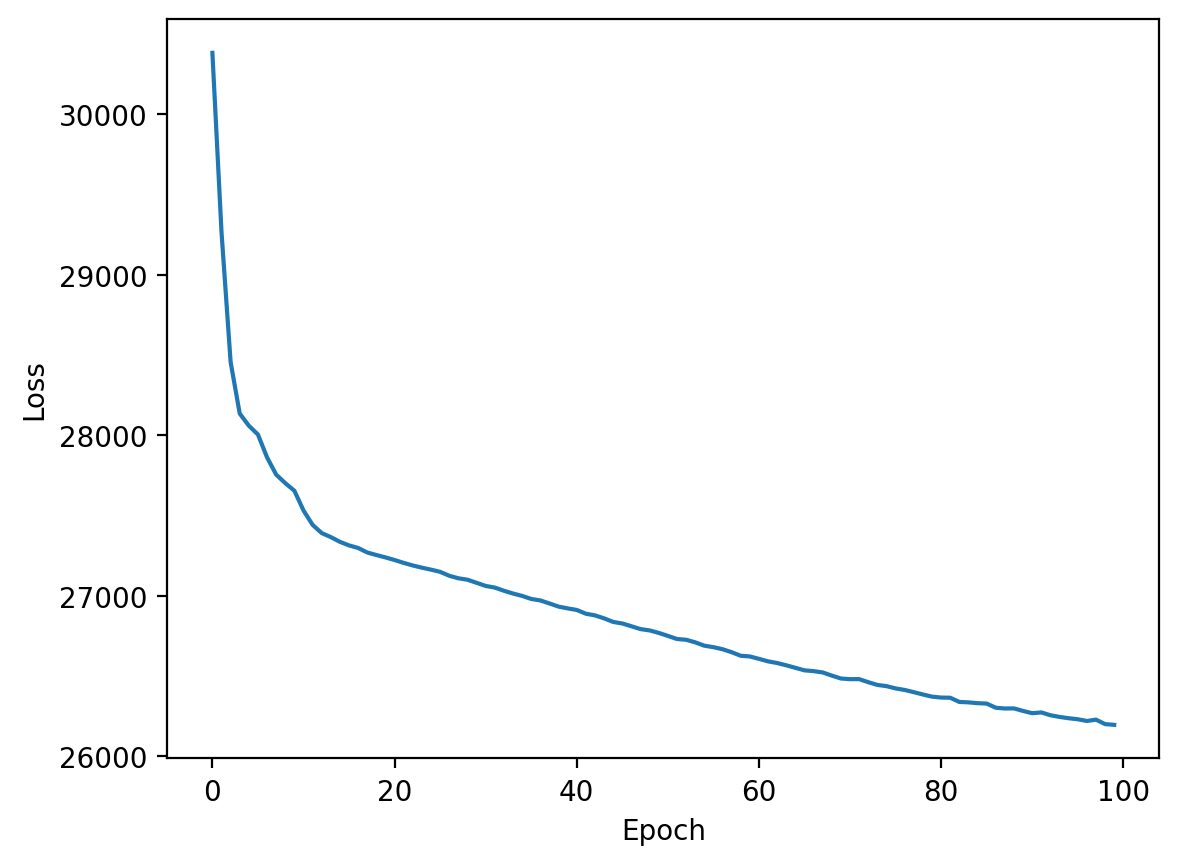

In [ ]:
# График Loss
plt.plot(history_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.manual_seed(45)         #зафиксируем рандом
x_rand = (torch.rand(10,200)*512).to(device)
x_rand.size()

torch.Size([10, 200])

In [ ]:

for i in range(x_rand.size(0)):
  x_r = x_rand[i]  # Извлекаем одну строку тензора
  pict_hat = vae.decoder(x_r).to(device)  # Получим изображение
  save_image(pict_hat.view(3, 128, 128), 'drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№2'+ '_эксперимент_'+ str(i) + '.jpg')  # Сохраним изображение

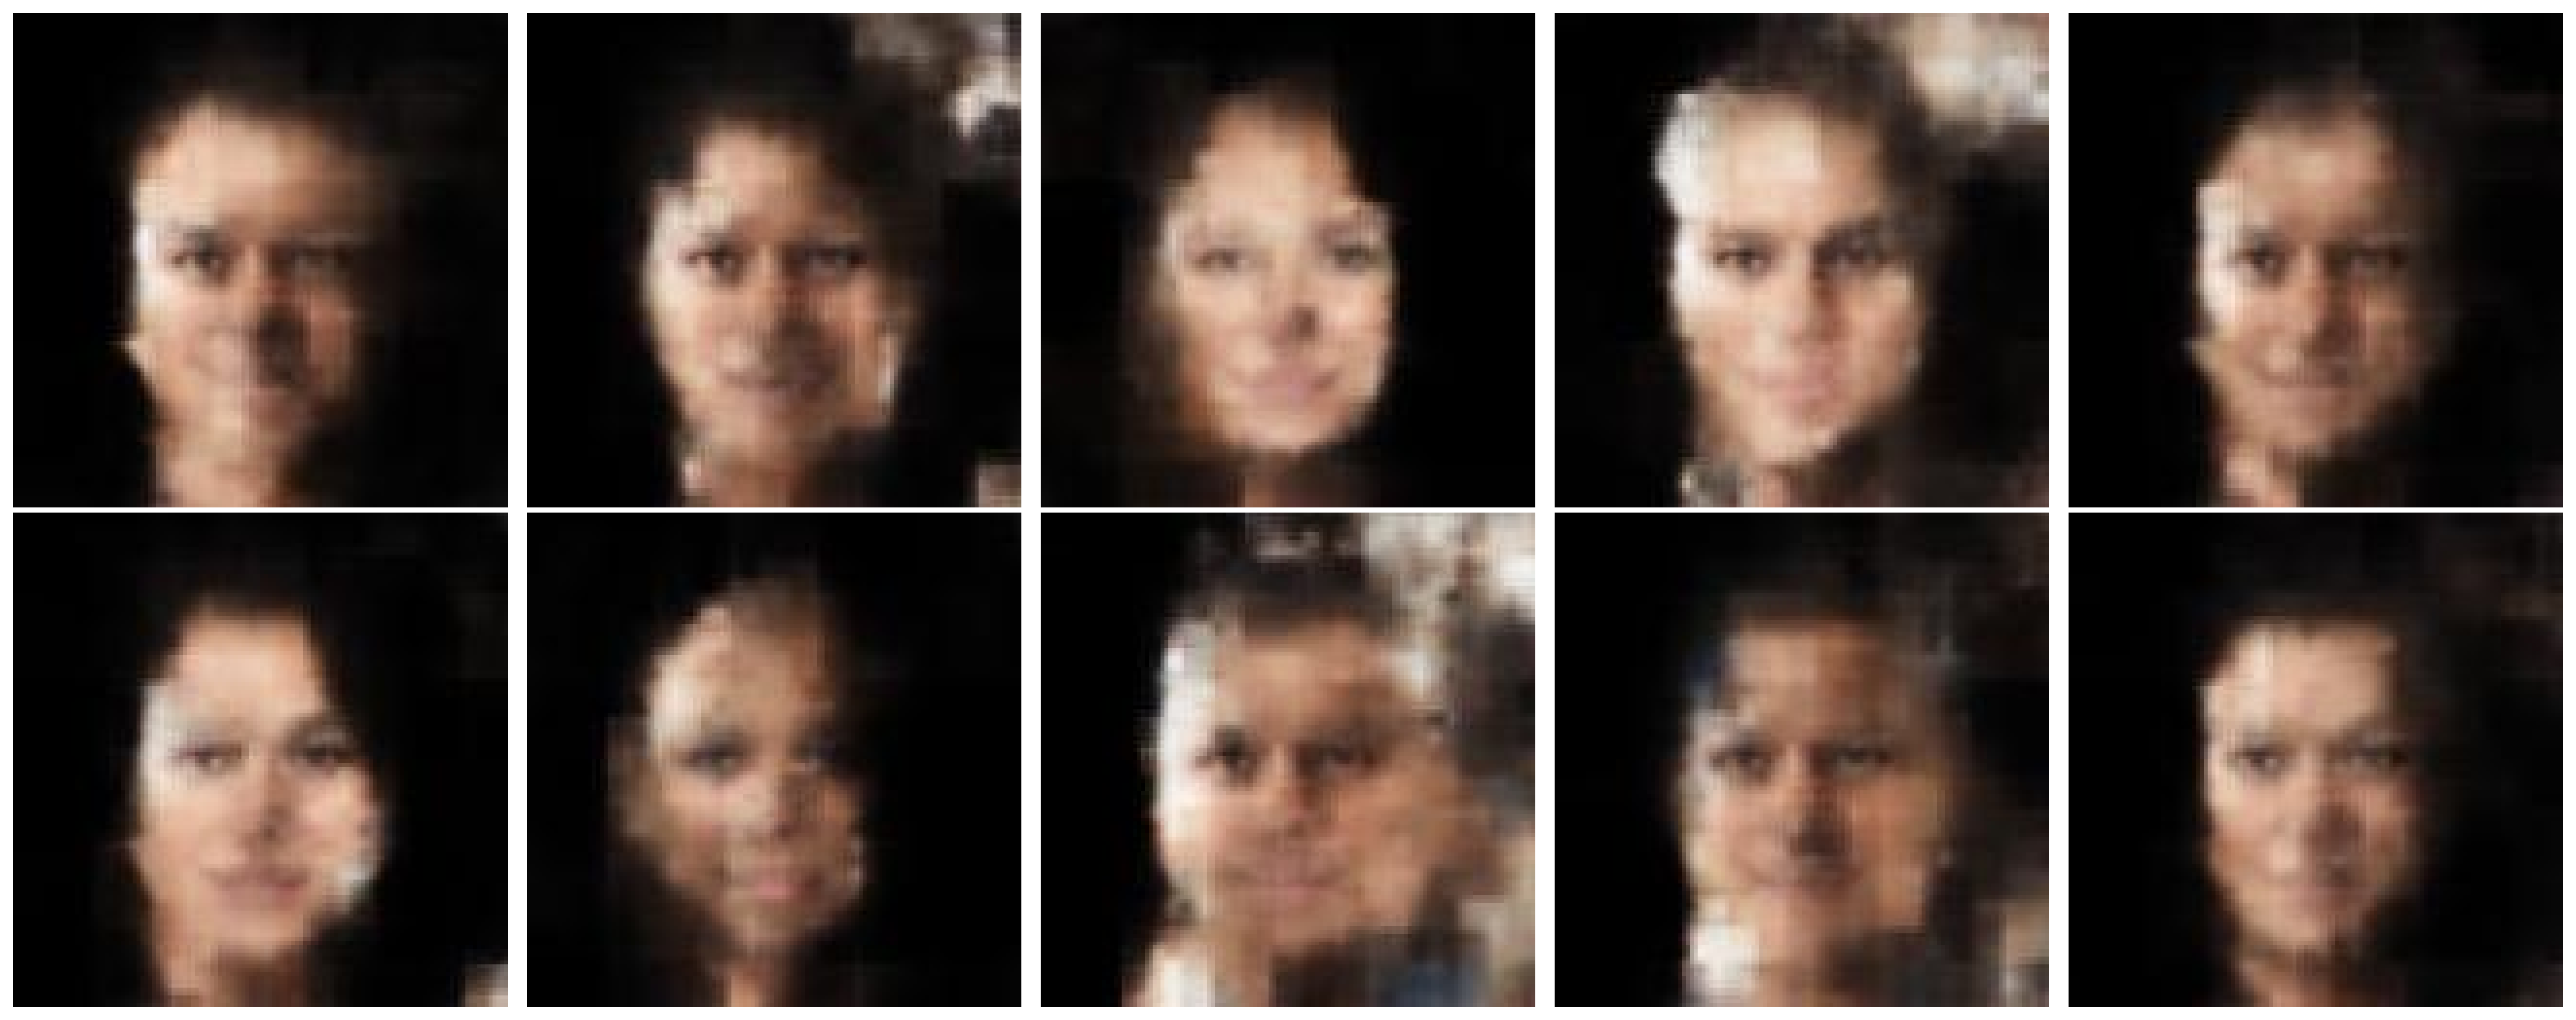

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(10):
  img_1 = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№2'+ '_эксперимент_'+ str(i) + '.jpg')
  axs[i//5, i%5].imshow(img_1)
  axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vae_3, 'drive/MyDrive/Colab_Notebooks/SM/SM_1/Model/model2.pt')

## **1.3 Вариационный энкодер и декодер. Сборка и обучение. Увеличил количество фильтров**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (128-4+2*1)/2+1=64 ).
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=2, stride=2, padding=0) # Слой свёртки. Размер карты активации( (64-2+2*0)/2+1=32 ).
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=164, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (32-4+2*1)/2+1=16 ).
        self.conv4 = nn.Conv2d(in_channels=164, out_channels=256, kernel_size=4, stride=4, padding=2) # Слой свёртки. Размер карты активации( (16-4+2*2)/4+1=5 ).

        self.linear1 = nn.Linear(256*5*5, 512)           #Скрытый внутренний слой.
        self.linear2 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.
        self.linear3 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)               # Получаем вектор(вытягиваем нашу картинку).
        x = F.relu(self.linear1(x))                     # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.

        self.mu =  self.linear2(x)                      # Присваиваем результат применения линейного слоя 2. Входная пере менная x.
        self.log_var = self.linear3(x)

        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu

        return z                                    # возврацение результата z.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.linear_b1 = nn.Linear(latent_dims, 512)
        self.linear_b2 = nn.Linear(512, 256*5*5)

        self.convTr1 = nn.ConvTranspose2d(in_channels=256, out_channels=164, kernel_size=4, stride=4, padding=2)
        self.convTr2 = nn.ConvTranspose2d(in_channels=164, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.convTr3 = nn.ConvTranspose2d(in_channels=128, out_channels=96, kernel_size=2, stride=2, padding=0)
        self.convTr4 = nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.linear_b1(z))            # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        z = torch.sigmoid(self.linear_b2(z))     # Выполнение прямого прохода через второй линейный слой с функцией активации сигмоид.
        z = z.reshape((-1, 256, 5, 5))         # Изменение формы в соответствии с размерами изображения 28x28.
        z = F.relu(self.convTr1(z))
        z = F.relu(self.convTr2(z))
        z = F.relu(self.convTr3(z))
        z = torch.sigmoid(self.convTr4(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):                # Собираем вариационный энкодер
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  #Вариационный энкодер
        self.decoder = Decoder(latent_dims)             # Декодер

    def forward(self, x):
        z = self.encoder(x)                             # Подаём входные данные на энкодер
        return self.decoder(z)                          # Далее на декодер и выдаём результат.

In [ ]:
print()
def train(autoencoder, data, history_loss, epochs=10):              # Создадим функцию обучения.
    opt = torch.optim.Adam(autoencoder.parameters()   )             # Оптимизатор Adam.

    for epoch in tqdm.tqdm(range(epochs)):            # Проходим по эпохам, активируем шкалу прогресса.
        t_loss = 0
        for x,y in data:
            x = x.to(device) # GPU                    # Отправляем на устройство.
            opt.zero_grad()                           # Обнуляем градиенты.
            x_hat = autoencoder(x)                    # Получим спрогназированное(восстановленное) значение.

            r_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + autoencoder.encoder.log_var - autoencoder.encoder.mu ** 2 - autoencoder.encoder.log_var.exp())
            loss = r_loss + kld_loss

            loss.backward()                           # Пройдём обратным распространением, посчитаем все градиенты.
            t_loss += loss.item()
            opt.step()                                 # Оптимизируем параметры сети.

        history_loss.append(t_loss / len(data.dataset))
        print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, t_loss / len(data.dataset)))
        print("-------------------------------------------------")

    return autoencoder, history_loss                               # Вернём результат.

In [ ]:
latent_dims = 200                                             # Выберем размерность скрытого представления (латентного пространства).
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # Создание экземпляра модели с заданной размерностью скрытого представления и
                                                              # и перенос этой модели на используемое устройство.

In [ ]:
history_loss = []
vae = VariationalAutoencoder(latent_dims).to(device)          #Создадим функцию, и перенесём её на используемое устройство.
vae_3 = train(vae, data, history_loss, epochs=100)             # Выполним обучение.

  1%|          | 1/100 [00:33<55:30, 33.64s/it]

Epoch: 0 Train mean loss: 28465.44427785
-------------------------------------------------


  2%|▏         | 2/100 [01:06<54:30, 33.37s/it]

Epoch: 1 Train mean loss: 27028.49597613
-------------------------------------------------


  3%|▎         | 3/100 [01:40<53:50, 33.30s/it]

Epoch: 2 Train mean loss: 26705.65415392
-------------------------------------------------


  4%|▍         | 4/100 [02:13<53:21, 33.35s/it]

Epoch: 3 Train mean loss: 26528.37911822
-------------------------------------------------


  5%|▌         | 5/100 [02:46<52:43, 33.30s/it]

Epoch: 4 Train mean loss: 26386.77157538
-------------------------------------------------


  6%|▌         | 6/100 [03:19<52:09, 33.29s/it]

Epoch: 5 Train mean loss: 26238.74612658
-------------------------------------------------


  7%|▋         | 7/100 [03:54<52:09, 33.65s/it]

Epoch: 6 Train mean loss: 26097.98857864
-------------------------------------------------


  8%|▊         | 8/100 [04:27<51:25, 33.54s/it]

Epoch: 7 Train mean loss: 26005.73990973
-------------------------------------------------


  9%|▉         | 9/100 [05:00<50:46, 33.48s/it]

Epoch: 8 Train mean loss: 25934.21351999
-------------------------------------------------


 10%|█         | 10/100 [05:34<50:07, 33.42s/it]

Epoch: 9 Train mean loss: 25861.84309466
-------------------------------------------------


 11%|█         | 11/100 [06:07<49:39, 33.48s/it]

Epoch: 10 Train mean loss: 25810.22752193
-------------------------------------------------


 12%|█▏        | 12/100 [06:41<48:58, 33.40s/it]

Epoch: 11 Train mean loss: 25748.67770298
-------------------------------------------------


 13%|█▎        | 13/100 [07:14<48:21, 33.36s/it]

Epoch: 12 Train mean loss: 25702.33147695
-------------------------------------------------


 14%|█▍        | 14/100 [07:47<47:46, 33.33s/it]

Epoch: 13 Train mean loss: 25655.17569104
-------------------------------------------------


 15%|█▌        | 15/100 [08:20<47:11, 33.31s/it]

Epoch: 14 Train mean loss: 25617.88004896
-------------------------------------------------


 16%|█▌        | 16/100 [08:54<46:46, 33.41s/it]

Epoch: 15 Train mean loss: 25581.95349092
-------------------------------------------------


 17%|█▋        | 17/100 [09:28<46:15, 33.44s/it]

Epoch: 16 Train mean loss: 25543.36992044
-------------------------------------------------


 18%|█▊        | 18/100 [10:01<45:44, 33.47s/it]

Epoch: 17 Train mean loss: 25503.03506732
-------------------------------------------------


 19%|█▉        | 19/100 [10:35<45:22, 33.62s/it]

Epoch: 18 Train mean loss: 25475.04483884
-------------------------------------------------


 20%|██        | 20/100 [11:09<44:51, 33.64s/it]

Epoch: 19 Train mean loss: 25440.87509435
-------------------------------------------------


 21%|██        | 21/100 [11:42<44:11, 33.56s/it]

Epoch: 20 Train mean loss: 25417.30012750
-------------------------------------------------


 22%|██▏       | 22/100 [12:15<43:31, 33.48s/it]

Epoch: 21 Train mean loss: 25387.07280957
-------------------------------------------------


 23%|██▎       | 23/100 [12:49<42:58, 33.48s/it]

Epoch: 22 Train mean loss: 25360.02416616
-------------------------------------------------


 24%|██▍       | 24/100 [13:22<42:19, 33.42s/it]

Epoch: 23 Train mean loss: 25333.35586495
-------------------------------------------------


 25%|██▌       | 25/100 [13:56<41:47, 33.44s/it]

Epoch: 24 Train mean loss: 25306.07948541
-------------------------------------------------


 26%|██▌       | 26/100 [14:29<41:16, 33.47s/it]

Epoch: 25 Train mean loss: 25287.65019380
-------------------------------------------------


 27%|██▋       | 27/100 [15:03<40:43, 33.48s/it]

Epoch: 26 Train mean loss: 25263.80058650
-------------------------------------------------


 28%|██▊       | 28/100 [15:36<40:07, 33.44s/it]

Epoch: 27 Train mean loss: 25244.28232609
-------------------------------------------------


 29%|██▉       | 29/100 [16:09<39:29, 33.38s/it]

Epoch: 28 Train mean loss: 25222.74643513
-------------------------------------------------


 30%|███       | 30/100 [16:43<38:57, 33.39s/it]

Epoch: 29 Train mean loss: 25205.68713025
-------------------------------------------------


 31%|███       | 31/100 [17:16<38:22, 33.37s/it]

Epoch: 30 Train mean loss: 25187.59669268
-------------------------------------------------


 32%|███▏      | 32/100 [17:49<37:48, 33.36s/it]

Epoch: 31 Train mean loss: 25173.68457517
-------------------------------------------------


 33%|███▎      | 33/100 [18:23<37:22, 33.46s/it]

Epoch: 32 Train mean loss: 25153.20160649
-------------------------------------------------


 34%|███▍      | 34/100 [18:56<36:43, 33.38s/it]

Epoch: 33 Train mean loss: 25141.32360516
-------------------------------------------------


 35%|███▌      | 35/100 [19:30<36:12, 33.42s/it]

Epoch: 34 Train mean loss: 25125.58847154
-------------------------------------------------


 36%|███▌      | 36/100 [20:03<35:40, 33.44s/it]

Epoch: 35 Train mean loss: 25113.97281977
-------------------------------------------------


 37%|███▋      | 37/100 [20:37<35:03, 33.39s/it]

Epoch: 36 Train mean loss: 25101.17340881
-------------------------------------------------


 38%|███▊      | 38/100 [21:10<34:32, 33.43s/it]

Epoch: 37 Train mean loss: 25086.58057171
-------------------------------------------------


 39%|███▉      | 39/100 [21:43<33:57, 33.40s/it]

Epoch: 38 Train mean loss: 25072.47945481
-------------------------------------------------


 40%|████      | 40/100 [22:17<33:25, 33.42s/it]

Epoch: 39 Train mean loss: 25062.20523001
-------------------------------------------------


 41%|████      | 41/100 [22:50<32:48, 33.37s/it]

Epoch: 40 Train mean loss: 25051.86462923
-------------------------------------------------


 42%|████▏     | 42/100 [23:24<32:18, 33.41s/it]

Epoch: 41 Train mean loss: 25038.34179162
-------------------------------------------------


 43%|████▎     | 43/100 [23:57<31:47, 33.47s/it]

Epoch: 42 Train mean loss: 25032.41291055
-------------------------------------------------


 44%|████▍     | 44/100 [24:31<31:18, 33.54s/it]

Epoch: 43 Train mean loss: 25023.98022236
-------------------------------------------------


 45%|████▌     | 45/100 [25:04<30:44, 33.53s/it]

Epoch: 44 Train mean loss: 25009.68345318
-------------------------------------------------


 46%|████▌     | 46/100 [25:38<30:10, 33.54s/it]

Epoch: 45 Train mean loss: 25000.08207874
-------------------------------------------------


 47%|████▋     | 47/100 [26:12<29:39, 33.58s/it]

Epoch: 46 Train mean loss: 24995.45348072
-------------------------------------------------


 48%|████▊     | 48/100 [26:45<29:01, 33.49s/it]

Epoch: 47 Train mean loss: 24986.49162077
-------------------------------------------------


 49%|████▉     | 49/100 [27:19<28:30, 33.54s/it]

Epoch: 48 Train mean loss: 24976.54504539
-------------------------------------------------


 50%|█████     | 50/100 [27:52<27:56, 33.53s/it]

Epoch: 49 Train mean loss: 24970.60983017
-------------------------------------------------


 51%|█████     | 51/100 [28:26<27:21, 33.50s/it]

Epoch: 50 Train mean loss: 24962.45970522
-------------------------------------------------


 52%|█████▏    | 52/100 [28:59<26:51, 33.58s/it]

Epoch: 51 Train mean loss: 24958.19477254
-------------------------------------------------


 53%|█████▎    | 53/100 [29:33<26:19, 33.61s/it]

Epoch: 52 Train mean loss: 24945.82104498
-------------------------------------------------


 54%|█████▍    | 54/100 [30:07<25:45, 33.59s/it]

Epoch: 53 Train mean loss: 24944.11576652
-------------------------------------------------


 55%|█████▌    | 55/100 [30:40<25:12, 33.62s/it]

Epoch: 54 Train mean loss: 24936.11557273
-------------------------------------------------


 56%|█████▌    | 56/100 [31:14<24:38, 33.59s/it]

Epoch: 55 Train mean loss: 24927.18774990
-------------------------------------------------


 57%|█████▋    | 57/100 [31:47<24:03, 33.57s/it]

Epoch: 56 Train mean loss: 24922.51794676
-------------------------------------------------


 58%|█████▊    | 58/100 [32:21<23:32, 33.63s/it]

Epoch: 57 Train mean loss: 24914.70794829
-------------------------------------------------


 59%|█████▉    | 59/100 [32:55<22:57, 33.60s/it]

Epoch: 58 Train mean loss: 24909.18517952
-------------------------------------------------


 60%|██████    | 60/100 [33:29<22:31, 33.79s/it]

Epoch: 59 Train mean loss: 24904.05439871
-------------------------------------------------


 61%|██████    | 61/100 [34:02<21:53, 33.68s/it]

Epoch: 60 Train mean loss: 24899.07343176
-------------------------------------------------


 62%|██████▏   | 62/100 [34:36<21:19, 33.68s/it]

Epoch: 61 Train mean loss: 24893.15319002
-------------------------------------------------


 63%|██████▎   | 63/100 [35:10<20:46, 33.68s/it]

Epoch: 62 Train mean loss: 24884.96280855
-------------------------------------------------


 64%|██████▍   | 64/100 [35:43<20:09, 33.61s/it]

Epoch: 63 Train mean loss: 24881.78908609
-------------------------------------------------


 65%|██████▌   | 65/100 [36:17<19:37, 33.65s/it]

Epoch: 64 Train mean loss: 24875.96185231
-------------------------------------------------


 66%|██████▌   | 66/100 [36:50<19:02, 33.60s/it]

Epoch: 65 Train mean loss: 24872.66246940
-------------------------------------------------


 67%|██████▋   | 67/100 [37:23<18:24, 33.47s/it]

Epoch: 66 Train mean loss: 24871.77991381
-------------------------------------------------


 68%|██████▊   | 68/100 [37:57<17:49, 33.43s/it]

Epoch: 67 Train mean loss: 24864.48181100
-------------------------------------------------


 69%|██████▉   | 69/100 [38:30<17:13, 33.34s/it]

Epoch: 68 Train mean loss: 24856.77645859
-------------------------------------------------


 70%|███████   | 70/100 [39:03<16:37, 33.25s/it]

Epoch: 69 Train mean loss: 24853.41639637
-------------------------------------------------


 71%|███████   | 71/100 [39:36<16:02, 33.19s/it]

Epoch: 70 Train mean loss: 24848.29845471
-------------------------------------------------


 72%|███████▏  | 72/100 [40:09<15:32, 33.29s/it]

Epoch: 71 Train mean loss: 24846.25026775
-------------------------------------------------


 73%|███████▎  | 73/100 [40:43<14:57, 33.25s/it]

Epoch: 72 Train mean loss: 24840.44931406
-------------------------------------------------


 74%|███████▍  | 74/100 [41:17<14:33, 33.59s/it]

Epoch: 73 Train mean loss: 24838.72656569
-------------------------------------------------


 75%|███████▌  | 75/100 [41:50<13:58, 33.54s/it]

Epoch: 74 Train mean loss: 24834.47356691
-------------------------------------------------


 76%|███████▌  | 76/100 [42:24<13:27, 33.65s/it]

Epoch: 75 Train mean loss: 24830.34747297
-------------------------------------------------


 77%|███████▋  | 77/100 [42:59<12:58, 33.85s/it]

Epoch: 76 Train mean loss: 24824.03221134
-------------------------------------------------


 78%|███████▊  | 78/100 [43:32<12:24, 33.83s/it]

Epoch: 77 Train mean loss: 24821.85164474
-------------------------------------------------


 79%|███████▉  | 79/100 [44:05<11:44, 33.56s/it]

Epoch: 78 Train mean loss: 24822.43051306
-------------------------------------------------


 80%|████████  | 80/100 [44:38<11:08, 33.41s/it]

Epoch: 79 Train mean loss: 24819.89285751
-------------------------------------------------


 81%|████████  | 81/100 [45:12<10:37, 33.57s/it]

Epoch: 80 Train mean loss: 24812.50217003
-------------------------------------------------


 82%|████████▏ | 82/100 [45:46<10:02, 33.47s/it]

Epoch: 81 Train mean loss: 24808.53586546
-------------------------------------------------


 83%|████████▎ | 83/100 [46:19<09:28, 33.45s/it]

Epoch: 82 Train mean loss: 24808.81655702
-------------------------------------------------


 84%|████████▍ | 84/100 [46:52<08:55, 33.44s/it]

Epoch: 83 Train mean loss: 24805.51117146
-------------------------------------------------


 85%|████████▌ | 85/100 [47:26<08:22, 33.49s/it]

Epoch: 84 Train mean loss: 24799.97165698
-------------------------------------------------


 86%|████████▌ | 86/100 [47:59<07:47, 33.43s/it]

Epoch: 85 Train mean loss: 24799.30492401
-------------------------------------------------


 87%|████████▋ | 87/100 [48:33<07:14, 33.44s/it]

Epoch: 86 Train mean loss: 24795.61042942
-------------------------------------------------


 88%|████████▊ | 88/100 [49:06<06:41, 33.45s/it]

Epoch: 87 Train mean loss: 24792.58671716
-------------------------------------------------


 89%|████████▉ | 89/100 [49:39<06:07, 33.37s/it]

Epoch: 88 Train mean loss: 24789.11453998
-------------------------------------------------


 90%|█████████ | 90/100 [50:13<05:33, 33.39s/it]

Epoch: 89 Train mean loss: 24787.95075479
-------------------------------------------------


 91%|█████████ | 91/100 [50:46<05:01, 33.45s/it]

Epoch: 90 Train mean loss: 24784.49699867
-------------------------------------------------


 92%|█████████▏| 92/100 [51:20<04:27, 33.43s/it]

Epoch: 91 Train mean loss: 24782.55034680
-------------------------------------------------


 93%|█████████▎| 93/100 [51:53<03:53, 33.41s/it]

Epoch: 92 Train mean loss: 24781.96540188
-------------------------------------------------


 94%|█████████▍| 94/100 [52:27<03:20, 33.38s/it]

Epoch: 93 Train mean loss: 24780.67246022
-------------------------------------------------


 95%|█████████▌| 95/100 [53:00<02:46, 33.35s/it]

Epoch: 94 Train mean loss: 24776.61530753
-------------------------------------------------


 96%|█████████▌| 96/100 [53:33<02:12, 33.24s/it]

Epoch: 95 Train mean loss: 24772.71809466
-------------------------------------------------


 97%|█████████▋| 97/100 [54:06<01:39, 33.22s/it]

Epoch: 96 Train mean loss: 24771.83168350
-------------------------------------------------


 98%|█████████▊| 98/100 [54:39<01:06, 33.26s/it]

Epoch: 97 Train mean loss: 24770.13738270
-------------------------------------------------


 99%|█████████▉| 99/100 [55:12<00:33, 33.21s/it]

Epoch: 98 Train mean loss: 24769.88117605
-------------------------------------------------


100%|██████████| 100/100 [55:46<00:00, 33.47s/it]

Epoch: 99 Train mean loss: 24768.27332466
-------------------------------------------------


In [ ]:
weights_3 = autoencoder.state_dict()                          #Веса модели.
#weights_3

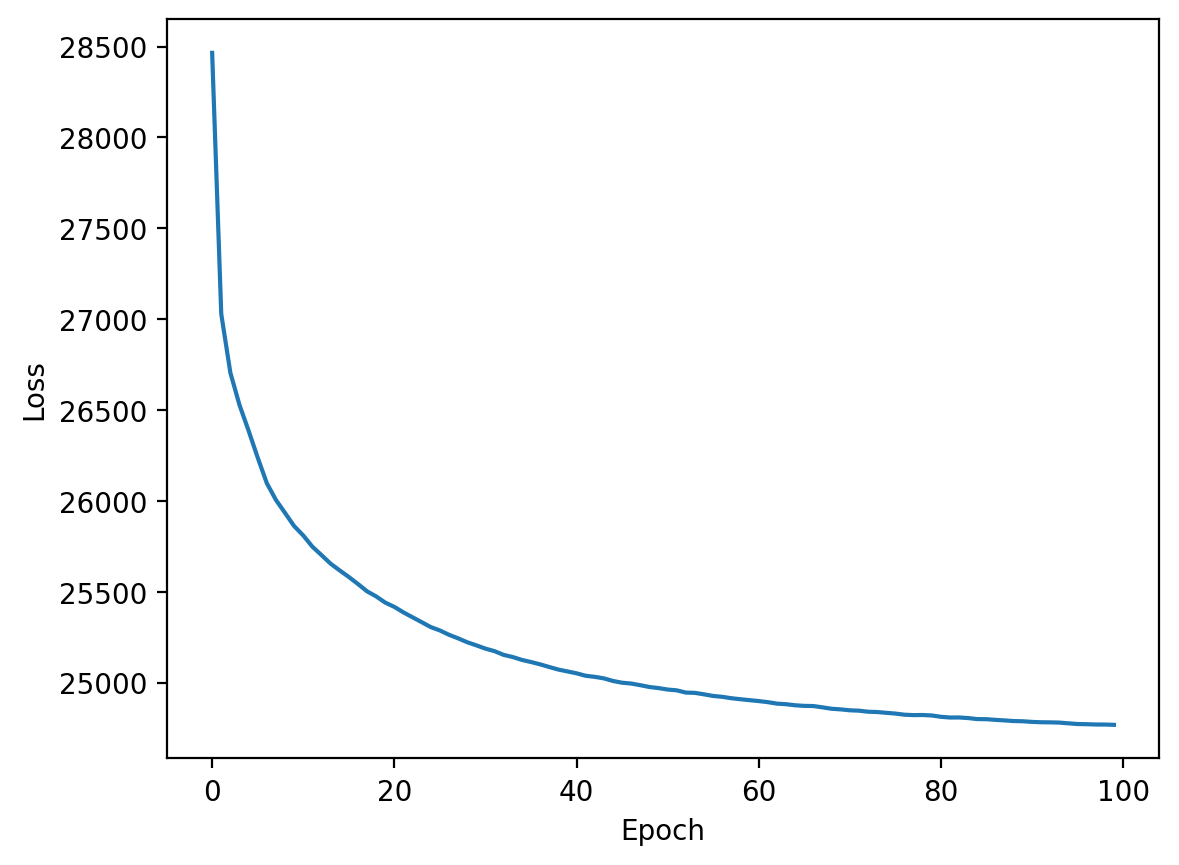

In [ ]:
# График Loss
plt.plot(history_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.manual_seed(45)         #зафиксируем рандом
x_rand = (torch.rand(10,200)*512).to(device)
x_rand.size()

torch.Size([10, 200])

In [ ]:

for i in range(x_rand.size(0)):
  x_r = x_rand[i]  # Извлекаем одну строку тензора
  pict_hat = vae.decoder(x_r).to(device)  # Получим изображение
  save_image(pict_hat.view(3, 128, 128), 'drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№3'+ '_эксперимент_'+ str(i) + '.jpg')  # Сохраним изображение

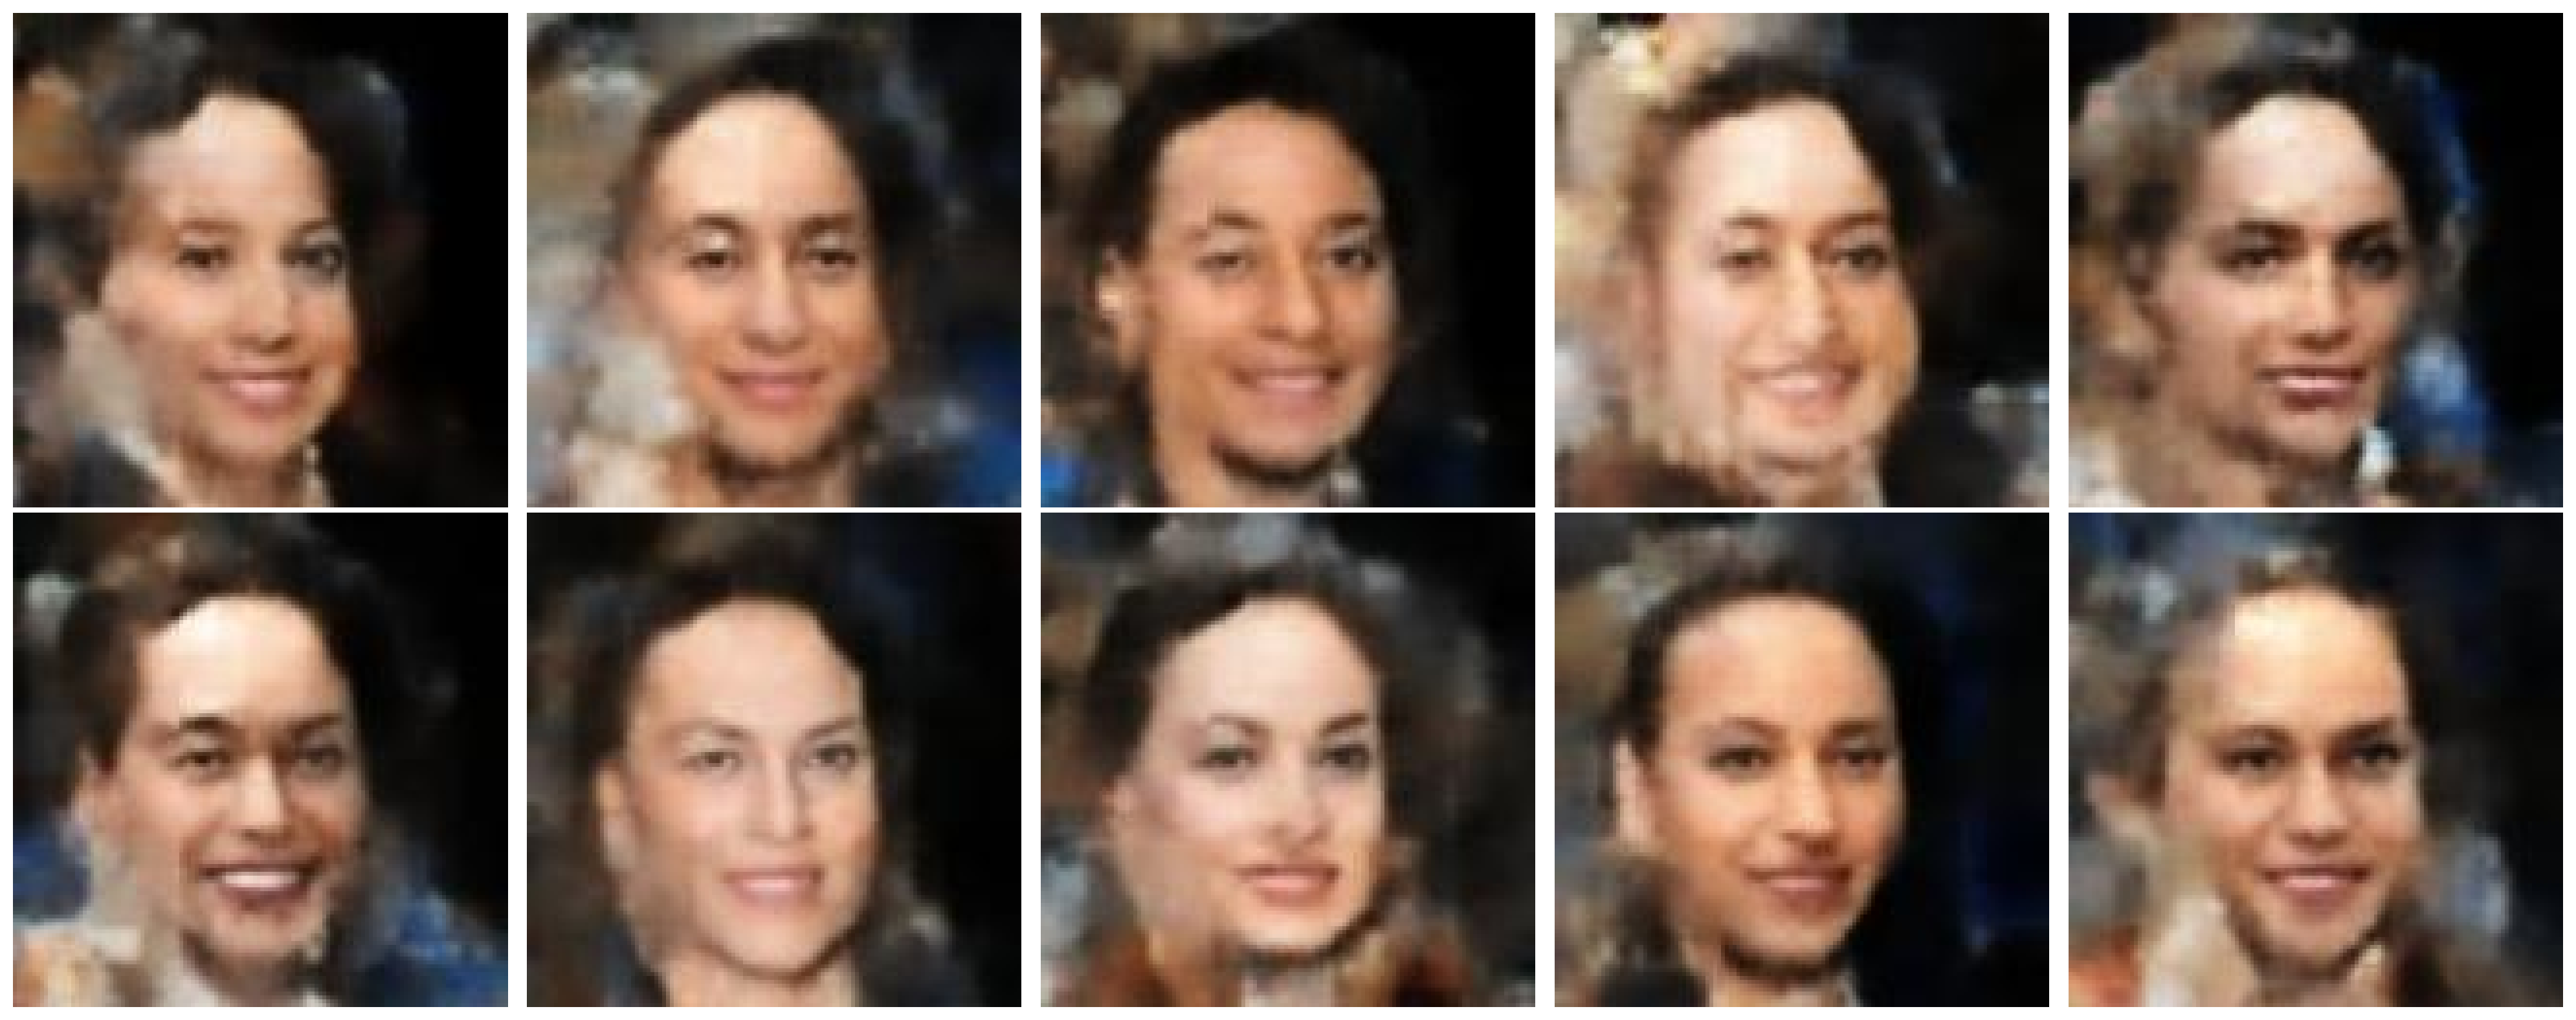

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(10):
  img_1 = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№3'+ '_эксперимент_'+ str(i) + '.jpg')
  axs[i//5, i%5].imshow(img_1)
  axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vae_3, 'drive/MyDrive/Colab_Notebooks/SM/SM_1/Model/model3.pt')

## **1.4 Вариационный энкодер и декодер. Сборка и обучение. Добавил 2 нелинейных слоя и увеличел количество фильров.**

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (128-4+2*1)/2+1=64 ).
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=2, stride=2, padding=0) # Слой свёртки. Размер карты активации( (64-2+2*0)/2+1=32 ).
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=164, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (32-4+2*1)/2+1=16 ).
        self.conv4 = nn.Conv2d(in_channels=164, out_channels=256, kernel_size=4, stride=4, padding=2) # Слой свёртки. Размер карты активации( (16-4+2*2)/4+1=5 ).

        self.linear1 = nn.Linear(256*5*5, 512)           #Скрытый внутренний слой.
        self.linear1_1 = nn.Linear(512,512)
        self.linear1_2 = nn.Linear(512,512)

        self.linear2 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.
        self.linear3 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)               # Получаем вектор(вытягиваем нашу картинку).
        x = F.relu(self.linear1(x))                     # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        x = F.relu(self.linear1_1(x))                   # Добавим 2 нелинейных слоя.
        x = F.relu(self.linear1_2(x))

        self.mu =  self.linear2(x)                      # Присваиваем результат применения линейного слоя 2. Входная пере менная x.
        self.log_var = self.linear3(x)

        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu

        return z                                    # возврацение результата z.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()



        self.linear_b1 = nn.Linear(latent_dims, 512)

        self.linear_b2_1 = nn.Linear(512,512)
        self.linear_b2_2 = nn.Linear(512,512)
        self.linear_b2 = nn.Linear(512, 256*5*5)

        self.convTr1 = nn.ConvTranspose2d(in_channels=256, out_channels=164, kernel_size=4, stride=4, padding=2)
        self.convTr2 = nn.ConvTranspose2d(in_channels=164, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.convTr3 = nn.ConvTranspose2d(in_channels=128, out_channels=96, kernel_size=2, stride=2, padding=0)
        self.convTr4 = nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.linear_b1(z))            # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        z = F.relu(self.linear_b2_1(z))
        z = F.relu(self.linear_b2_2(z))
        z = torch.sigmoid(self.linear_b2(z))     # Выполнение прямого прохода через второй линейный слой с функцией активации сигмоид.
        z = z.reshape((-1, 256, 5, 5))         # Изменение формы в соответствии с размерами изображения 28x28.
        z = F.relu(self.convTr1(z))
        z = F.relu(self.convTr2(z))
        z = F.relu(self.convTr3(z))
        z = torch.sigmoid(self.convTr4(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):                # Собираем вариационный энкодер
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  #Вариационный энкодер
        self.decoder = Decoder(latent_dims)             # Декодер

    def forward(self, x):
        z = self.encoder(x)                             # Подаём входные данные на энкодер
        return self.decoder(z)                          # Далее на декодер и выдаём результат.

In [ ]:
print()
def train(autoencoder, data, history_loss, epochs=10):              # Создадим функцию обучения.
    opt = torch.optim.Adam(autoencoder.parameters()   )             # Оптимизатор Adam.

    for epoch in tqdm.tqdm(range(epochs)):            # Проходим по эпохам, активируем шкалу прогресса.
        t_loss = 0
        for x,y in data:
            x = x.to(device) # GPU                    # Отправляем на устройство.
            opt.zero_grad()                           # Обнуляем градиенты.
            x_hat = autoencoder(x)                    # Получим спрогназированное(восстановленное) значение.

            r_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + autoencoder.encoder.log_var - autoencoder.encoder.mu ** 2 - autoencoder.encoder.log_var.exp())
            loss = r_loss + kld_loss

            loss.backward()                           # Пройдём обратным распространением, посчитаем все градиенты.
            t_loss += loss.item()
            opt.step()                                 # Оптимизируем параметры сети.

        history_loss.append(t_loss / len(data.dataset))
        print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, t_loss / len(data.dataset)))
        print("-------------------------------------------------")

    return autoencoder, history_loss                               # Вернём результат.

In [ ]:
latent_dims = 200                                             # Выберем размерность скрытого представления (латентного пространства).
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # Создание экземпляра модели с заданной размерностью скрытого представления и
                                                              # и перенос этой модели на используемое устройство.

In [ ]:
history_loss = []
vae = VariationalAutoencoder(latent_dims).to(device)          #Создадим функцию, и перенесём её на используемое устройство.
vae_4 = train(vae, data, history_loss, epochs=200)             # Выполним обучение.

  0%|          | 1/200 [00:33<1:51:31, 33.62s/it]

Epoch: 0 Train mean loss: 30226.66753366
-------------------------------------------------


  1%|          | 2/200 [01:07<1:50:39, 33.53s/it]

Epoch: 1 Train mean loss: 28890.68166565
-------------------------------------------------


  2%|▏         | 3/200 [01:40<1:49:48, 33.44s/it]

Epoch: 2 Train mean loss: 28401.96984649
-------------------------------------------------


  2%|▏         | 4/200 [02:13<1:49:13, 33.44s/it]

Epoch: 3 Train mean loss: 28125.33546257
-------------------------------------------------


  2%|▎         | 5/200 [02:48<1:50:01, 33.85s/it]

Epoch: 4 Train mean loss: 27927.03063035
-------------------------------------------------


  3%|▎         | 6/200 [03:22<1:49:27, 33.85s/it]

Epoch: 5 Train mean loss: 27781.70674215
-------------------------------------------------


  4%|▎         | 7/200 [03:55<1:48:25, 33.71s/it]

Epoch: 6 Train mean loss: 27733.59331140
-------------------------------------------------


  4%|▍         | 8/200 [04:29<1:47:54, 33.72s/it]

Epoch: 7 Train mean loss: 27694.34968125
-------------------------------------------------


  4%|▍         | 9/200 [05:03<1:47:15, 33.69s/it]

Epoch: 8 Train mean loss: 27669.49837821
-------------------------------------------------


  5%|▌         | 10/200 [05:36<1:46:41, 33.69s/it]

Epoch: 9 Train mean loss: 27541.09742197
-------------------------------------------------


  6%|▌         | 11/200 [06:11<1:46:45, 33.89s/it]

Epoch: 10 Train mean loss: 27443.55995257
-------------------------------------------------


  6%|▌         | 12/200 [06:45<1:46:55, 34.13s/it]

Epoch: 11 Train mean loss: 27400.41666157
-------------------------------------------------


  6%|▋         | 13/200 [07:19<1:46:00, 34.02s/it]

Epoch: 12 Train mean loss: 27376.79945940
-------------------------------------------------


  7%|▋         | 14/200 [07:53<1:45:08, 33.92s/it]

Epoch: 13 Train mean loss: 27343.96330069
-------------------------------------------------


  8%|▊         | 15/200 [08:27<1:44:45, 33.97s/it]

Epoch: 14 Train mean loss: 27326.68783915
-------------------------------------------------


  8%|▊         | 16/200 [09:00<1:43:47, 33.84s/it]

Epoch: 15 Train mean loss: 27299.58842054
-------------------------------------------------


  8%|▊         | 17/200 [09:34<1:42:50, 33.72s/it]

Epoch: 16 Train mean loss: 27289.65103274
-------------------------------------------------


  9%|▉         | 18/200 [10:07<1:42:13, 33.70s/it]

Epoch: 17 Train mean loss: 27267.76279580
-------------------------------------------------


 10%|▉         | 19/200 [10:41<1:41:32, 33.66s/it]

Epoch: 18 Train mean loss: 27248.27082058
-------------------------------------------------


 10%|█         | 20/200 [11:15<1:40:50, 33.61s/it]

Epoch: 19 Train mean loss: 27232.51556763
-------------------------------------------------


 10%|█         | 21/200 [11:48<1:40:21, 33.64s/it]

Epoch: 20 Train mean loss: 27212.64464759
-------------------------------------------------


 11%|█         | 22/200 [12:22<1:39:44, 33.62s/it]

Epoch: 21 Train mean loss: 27198.17617554
-------------------------------------------------


 12%|█▏        | 23/200 [12:55<1:39:03, 33.58s/it]

Epoch: 22 Train mean loss: 27184.07240667
-------------------------------------------------


 12%|█▏        | 24/200 [13:29<1:38:53, 33.71s/it]

Epoch: 23 Train mean loss: 27160.35798654
-------------------------------------------------


 12%|█▎        | 25/200 [14:03<1:38:10, 33.66s/it]

Epoch: 24 Train mean loss: 27153.27891932
-------------------------------------------------


 13%|█▎        | 26/200 [14:37<1:37:47, 33.72s/it]

Epoch: 25 Train mean loss: 27140.31415749
-------------------------------------------------


 14%|█▎        | 27/200 [15:10<1:37:06, 33.68s/it]

Epoch: 26 Train mean loss: 27119.38539117
-------------------------------------------------


 14%|█▍        | 28/200 [15:44<1:36:23, 33.62s/it]

Epoch: 27 Train mean loss: 27096.99767187
-------------------------------------------------


 14%|█▍        | 29/200 [16:17<1:35:42, 33.58s/it]

Epoch: 28 Train mean loss: 27090.77107558
-------------------------------------------------


 15%|█▌        | 30/200 [16:51<1:35:09, 33.58s/it]

Epoch: 29 Train mean loss: 27064.61660292
-------------------------------------------------


 16%|█▌        | 31/200 [17:24<1:34:32, 33.57s/it]

Epoch: 30 Train mean loss: 27055.01332874
-------------------------------------------------


 16%|█▌        | 32/200 [17:58<1:33:48, 33.51s/it]

Epoch: 31 Train mean loss: 27034.98000051
-------------------------------------------------


 16%|█▋        | 33/200 [18:31<1:33:27, 33.58s/it]

Epoch: 32 Train mean loss: 27031.55138719
-------------------------------------------------


 17%|█▋        | 34/200 [19:05<1:32:42, 33.51s/it]

Epoch: 33 Train mean loss: 27009.60124184
-------------------------------------------------


 18%|█▊        | 35/200 [19:38<1:32:15, 33.55s/it]

Epoch: 34 Train mean loss: 26990.78398103
-------------------------------------------------


 18%|█▊        | 36/200 [20:12<1:31:38, 33.53s/it]

Epoch: 35 Train mean loss: 26978.86952774
-------------------------------------------------


 18%|█▊        | 37/200 [20:45<1:31:05, 33.53s/it]

Epoch: 36 Train mean loss: 26960.58589351
-------------------------------------------------


 19%|█▉        | 38/200 [21:19<1:30:17, 33.44s/it]

Epoch: 37 Train mean loss: 26949.19352560
-------------------------------------------------


 20%|█▉        | 39/200 [21:52<1:29:32, 33.37s/it]

Epoch: 38 Train mean loss: 26926.20777489
-------------------------------------------------


 20%|██        | 40/200 [22:25<1:28:55, 33.35s/it]

Epoch: 39 Train mean loss: 26912.27184568
-------------------------------------------------


 20%|██        | 41/200 [22:59<1:28:33, 33.42s/it]

Epoch: 40 Train mean loss: 26895.86523358
-------------------------------------------------


 21%|██        | 42/200 [23:32<1:27:51, 33.37s/it]

Epoch: 41 Train mean loss: 26887.36795186
-------------------------------------------------


 22%|██▏       | 43/200 [24:06<1:27:23, 33.40s/it]

Epoch: 42 Train mean loss: 26864.19657283
-------------------------------------------------


 22%|██▏       | 44/200 [24:39<1:26:34, 33.30s/it]

Epoch: 43 Train mean loss: 26842.16144176
-------------------------------------------------


 22%|██▎       | 45/200 [25:12<1:25:49, 33.22s/it]

Epoch: 44 Train mean loss: 26836.36719451
-------------------------------------------------


 23%|██▎       | 46/200 [25:45<1:25:14, 33.21s/it]

Epoch: 45 Train mean loss: 26815.05512291
-------------------------------------------------


 24%|██▎       | 47/200 [26:18<1:24:34, 33.16s/it]

Epoch: 46 Train mean loss: 26798.17791718
-------------------------------------------------


 24%|██▍       | 48/200 [26:51<1:23:51, 33.10s/it]

Epoch: 47 Train mean loss: 26781.53071195
-------------------------------------------------


 24%|██▍       | 49/200 [27:24<1:23:15, 33.09s/it]

Epoch: 48 Train mean loss: 26762.48209404
-------------------------------------------------


 25%|██▌       | 50/200 [27:57<1:22:42, 33.08s/it]

Epoch: 49 Train mean loss: 26752.27534425
-------------------------------------------------


 26%|██▌       | 51/200 [28:30<1:22:00, 33.02s/it]

Epoch: 50 Train mean loss: 26739.40073439
-------------------------------------------------


 26%|██▌       | 52/200 [29:03<1:21:41, 33.12s/it]

Epoch: 51 Train mean loss: 26718.22158303
-------------------------------------------------


 26%|██▋       | 53/200 [29:36<1:21:11, 33.14s/it]

Epoch: 52 Train mean loss: 26709.89036363
-------------------------------------------------


 27%|██▋       | 54/200 [30:09<1:20:32, 33.10s/it]

Epoch: 53 Train mean loss: 26691.55528101
-------------------------------------------------


 28%|██▊       | 55/200 [30:42<1:19:54, 33.07s/it]

Epoch: 54 Train mean loss: 26675.02462005
-------------------------------------------------


 28%|██▊       | 56/200 [31:15<1:19:19, 33.05s/it]

Epoch: 55 Train mean loss: 26669.91126071
-------------------------------------------------


 28%|██▊       | 57/200 [31:49<1:19:24, 33.32s/it]

Epoch: 56 Train mean loss: 26644.25693339
-------------------------------------------------


 29%|██▉       | 58/200 [32:23<1:19:13, 33.48s/it]

Epoch: 57 Train mean loss: 26638.91664882
-------------------------------------------------


 30%|██▉       | 59/200 [32:56<1:18:30, 33.41s/it]

Epoch: 58 Train mean loss: 26620.84670033
-------------------------------------------------


 30%|███       | 60/200 [33:30<1:17:52, 33.38s/it]

Epoch: 59 Train mean loss: 26620.09524174
-------------------------------------------------


 30%|███       | 61/200 [34:03<1:17:11, 33.32s/it]

Epoch: 60 Train mean loss: 26586.93332058
-------------------------------------------------


 31%|███       | 62/200 [34:36<1:16:31, 33.27s/it]

Epoch: 61 Train mean loss: 26591.08585016
-------------------------------------------------


 32%|███▏      | 63/200 [35:10<1:16:07, 33.34s/it]

Epoch: 62 Train mean loss: 26565.31566197
-------------------------------------------------


 32%|███▏      | 64/200 [35:43<1:15:49, 33.45s/it]

Epoch: 63 Train mean loss: 26542.68342003
-------------------------------------------------


 32%|███▎      | 65/200 [36:17<1:15:13, 33.43s/it]

Epoch: 64 Train mean loss: 26544.39010098
-------------------------------------------------


 33%|███▎      | 66/200 [36:50<1:14:33, 33.39s/it]

Epoch: 65 Train mean loss: 26526.47921767
-------------------------------------------------


 34%|███▎      | 67/200 [37:23<1:13:55, 33.35s/it]

Epoch: 66 Train mean loss: 26523.22674674
-------------------------------------------------


 34%|███▍      | 68/200 [37:57<1:13:22, 33.35s/it]

Epoch: 67 Train mean loss: 26505.49053703
-------------------------------------------------


 34%|███▍      | 69/200 [38:30<1:12:42, 33.30s/it]

Epoch: 68 Train mean loss: 26487.04495359
-------------------------------------------------


 35%|███▌      | 70/200 [39:04<1:12:35, 33.51s/it]

Epoch: 69 Train mean loss: 26485.89289066
-------------------------------------------------


 36%|███▌      | 71/200 [39:37<1:11:54, 33.45s/it]

Epoch: 70 Train mean loss: 26476.91047532
-------------------------------------------------


 36%|███▌      | 72/200 [40:11<1:11:23, 33.46s/it]

Epoch: 71 Train mean loss: 26468.31066911
-------------------------------------------------


 36%|███▋      | 73/200 [40:44<1:10:45, 33.43s/it]

Epoch: 72 Train mean loss: 26445.33208894
-------------------------------------------------


 37%|███▋      | 74/200 [41:17<1:10:09, 33.41s/it]

Epoch: 73 Train mean loss: 26430.34185027
-------------------------------------------------


 38%|███▊      | 75/200 [41:50<1:09:24, 33.32s/it]

Epoch: 74 Train mean loss: 26435.48235924
-------------------------------------------------


 38%|███▊      | 76/200 [42:24<1:08:53, 33.33s/it]

Epoch: 75 Train mean loss: 26416.19807222
-------------------------------------------------


 38%|███▊      | 77/200 [42:57<1:08:19, 33.33s/it]

Epoch: 76 Train mean loss: 26397.10232048
-------------------------------------------------


 39%|███▉      | 78/200 [43:30<1:07:41, 33.29s/it]

Epoch: 77 Train mean loss: 26401.73479957
-------------------------------------------------


 40%|███▉      | 79/200 [44:04<1:07:06, 33.28s/it]

Epoch: 78 Train mean loss: 26368.47484700
-------------------------------------------------


 40%|████      | 80/200 [44:37<1:06:49, 33.41s/it]

Epoch: 79 Train mean loss: 26386.31771726
-------------------------------------------------


 40%|████      | 81/200 [45:10<1:06:06, 33.33s/it]

Epoch: 80 Train mean loss: 26372.80756834
-------------------------------------------------


 41%|████      | 82/200 [45:44<1:05:34, 33.35s/it]

Epoch: 81 Train mean loss: 26359.54565228
-------------------------------------------------


 42%|████▏     | 83/200 [46:17<1:04:57, 33.31s/it]

Epoch: 82 Train mean loss: 26339.50818033
-------------------------------------------------


 42%|████▏     | 84/200 [46:50<1:04:25, 33.33s/it]

Epoch: 83 Train mean loss: 26327.67349041
-------------------------------------------------


 42%|████▎     | 85/200 [47:24<1:03:48, 33.29s/it]

Epoch: 84 Train mean loss: 26332.92251377
-------------------------------------------------


 43%|████▎     | 86/200 [47:57<1:03:17, 33.31s/it]

Epoch: 85 Train mean loss: 26313.74330120
-------------------------------------------------


 44%|████▎     | 87/200 [48:30<1:02:44, 33.32s/it]

Epoch: 86 Train mean loss: 26309.34967615
-------------------------------------------------


 44%|████▍     | 88/200 [49:04<1:02:15, 33.35s/it]

Epoch: 87 Train mean loss: 26298.48037026
-------------------------------------------------


In [ ]:
weights_4 = autoencoder.state_dict()                          #Веса модели.
#weights_4

In [ ]:
# График Loss
plt.plot(history_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.manual_seed(45)         #зафиксируем рандом
x_rand = (torch.rand(10,200)*512).to(device)
x_rand.size()

In [ ]:

for i in range(x_rand.size(0)):
  x_r = x_rand[i]  # Извлекаем одну строку тензора
  pict_hat = vae.decoder(x_r).to(device)  # Получим изображение
  save_image(pict_hat.view(3, 128, 128), 'drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№4'+ '_эксперимент_'+ str(i) + '.jpg')  # Сохраним изображение

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(10):
  img_1 = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№4'+ '_эксперимент_'+ str(i) + '.jpg')
  axs[i//5, i%5].imshow(img_1)
  axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vae_4, 'drive/MyDrive/Colab_Notebooks/SM/SM_1/Model/model4.pt')

## **1.5 Вариационный энкодер и декодер. Сборка и обучение. Добавил 2 нелинейных слоя и увеличел количество фильров. Добавил sheduler c gamma=0.5.**

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (128-4+2*1)/2+1=64 ).
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=2, stride=2, padding=0) # Слой свёртки. Размер карты активации( (64-2+2*0)/2+1=32 ).
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=164, kernel_size=4, stride=2, padding=1) # Слой свёртки. Размер карты активации( (32-4+2*1)/2+1=16 ).
        self.conv4 = nn.Conv2d(in_channels=164, out_channels=256, kernel_size=4, stride=4, padding=2) # Слой свёртки. Размер карты активации( (16-4+2*2)/4+1=5 ).

        self.linear1 = nn.Linear(256*5*5, 512)           #Скрытый внутренний слой.
        self.linear1_1 = nn.Linear(512,512)
        self.linear1_2 = nn.Linear(512,512)

        self.linear2 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.
        self.linear3 = nn.Linear(512, latent_dims)       #Скрытый внутренний слой.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)               # Получаем вектор(вытягиваем нашу картинку).
        x = F.relu(self.linear1(x))                     # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        x = F.relu(self.linear1_1(x))                   # Добавим 2 нелинейных слоя.
        x = F.relu(self.linear1_2(x))

        self.mu =  self.linear2(x)                      # Присваиваем результат применения линейного слоя 2. Входная пере менная x.
        self.log_var = self.linear3(x)

        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn_like(std)
        z = eps * std + self.mu

        return z                                    # возврацение результата z.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()



        self.linear_b1 = nn.Linear(latent_dims, 512)

        self.linear_b2_1 = nn.Linear(512,512)
        self.linear_b2_2 = nn.Linear(512,512)
        self.linear_b2 = nn.Linear(512, 256*5*5)

        self.convTr1 = nn.ConvTranspose2d(in_channels=256, out_channels=164, kernel_size=4, stride=4, padding=2)
        self.convTr2 = nn.ConvTranspose2d(in_channels=164, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.convTr3 = nn.ConvTranspose2d(in_channels=128, out_channels=96, kernel_size=2, stride=2, padding=0)
        self.convTr4 = nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = F.relu(self.linear_b1(z))            # Выполнение прямого прохода через первый линейный слой с функцией активации ReLU.
        z = F.relu(self.linear_b2_1(z))
        z = F.relu(self.linear_b2_2(z))
        z = torch.sigmoid(self.linear_b2(z))     # Выполнение прямого прохода через второй линейный слой с функцией активации сигмоид.
        z = z.reshape((-1, 256, 5, 5))         # Изменение формы в соответствии с размерами изображения 28x28.
        z = F.relu(self.convTr1(z))
        z = F.relu(self.convTr2(z))
        z = F.relu(self.convTr3(z))
        z = torch.sigmoid(self.convTr4(z))
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):                # Собираем вариационный энкодер
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)  #Вариационный энкодер
        self.decoder = Decoder(latent_dims)             # Декодер

    def forward(self, x):
        z = self.encoder(x)                             # Подаём входные данные на энкодер
        return self.decoder(z)                          # Далее на декодер и выдаём результат.

In [ ]:
print()
def train(autoencoder, data, history_loss, epochs=10, lr_sched=None):              # Создадим функцию обучения.
    opt = torch.optim.Adam(autoencoder.parameters() )             # Оптимизатор Adam.
    if lr_sched is not None:
        scheduler = lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.5)

    for epoch in tqdm.tqdm(range(epochs)):            # Проходим по эпохам, активируем шкалу прогресса.
        t_loss = 0
        for x,y in data:
            x = x.to(device) # GPU                    # Отправляем на устройство.
            opt.zero_grad()                           # Обнуляем градиенты.
            x_hat = autoencoder(x)                    # Получим спрогназированное(восстановленное) значение.

            r_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + autoencoder.encoder.log_var - autoencoder.encoder.mu ** 2 - autoencoder.encoder.log_var.exp())
            loss = r_loss + kld_loss

            loss.backward()                           # Пройдём обратным распространением, посчитаем все градиенты.
            t_loss += loss.item()
            opt.step()                                 # Оптимизируем параметры сети.


        history_loss.append(t_loss / len(data.dataset))
        print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, t_loss / len(data.dataset)))
        print("-------------------------------------------------")

        if lr_sched is not None:
          scheduler.step()
          print(f'текущий learning rate: {scheduler.get_last_lr()[0]}')


    return autoencoder, history_loss                               # Вернём результат.

In [ ]:
latent_dims = 200                                             # Выберем размерность скрытого представления (латентного пространства).
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # Создание экземпляра модели с заданной размерностью скрытого представления и
                                                              # и перенос этой модели на используемое устройство.

In [ ]:
history_loss = []
vae = VariationalAutoencoder(latent_dims).to(device)          #Создадим функцию, и перенесём её на используемое устройство.
vae_5 = train(vae, data, history_loss, epochs=10, lr_sched='scheduler')             # Выполним обучение.

 10%|█         | 1/10 [00:35<05:19, 35.54s/it]

Epoch: 0 Train mean loss: 30263.78040086
-------------------------------------------------
текущий learning rate: 0.0005


 20%|██        | 2/10 [01:13<04:58, 37.25s/it]

Epoch: 1 Train mean loss: 28745.54096287
-------------------------------------------------
текущий learning rate: 0.00025


 30%|███       | 3/10 [01:53<04:28, 38.35s/it]

Epoch: 2 Train mean loss: 28468.96285190
-------------------------------------------------
текущий learning rate: 0.000125


 40%|████      | 4/10 [02:31<03:50, 38.35s/it]

Epoch: 3 Train mean loss: 28388.78105875
-------------------------------------------------
текущий learning rate: 6.25e-05


 50%|█████     | 5/10 [03:08<03:09, 37.85s/it]

Epoch: 4 Train mean loss: 28346.95757599
-------------------------------------------------
текущий learning rate: 3.125e-05


 60%|██████    | 6/10 [03:45<02:29, 37.25s/it]

Epoch: 5 Train mean loss: 28323.82418911
-------------------------------------------------
текущий learning rate: 1.5625e-05


 70%|███████   | 7/10 [04:22<01:51, 37.29s/it]

Epoch: 6 Train mean loss: 28311.72293452
-------------------------------------------------
текущий learning rate: 7.8125e-06


 80%|████████  | 8/10 [04:57<01:13, 36.73s/it]

Epoch: 7 Train mean loss: 28302.28329508
-------------------------------------------------
текущий learning rate: 3.90625e-06


 90%|█████████ | 9/10 [05:33<00:36, 36.24s/it]

Epoch: 8 Train mean loss: 28299.22764688
-------------------------------------------------
текущий learning rate: 1.953125e-06


100%|██████████| 10/10 [06:08<00:00, 36.84s/it]

Epoch: 9 Train mean loss: 28295.62845267
-------------------------------------------------
текущий learning rate: 9.765625e-07


In [ ]:
weights_5 = autoencoder.state_dict()                          #Веса модели.
#weights_5

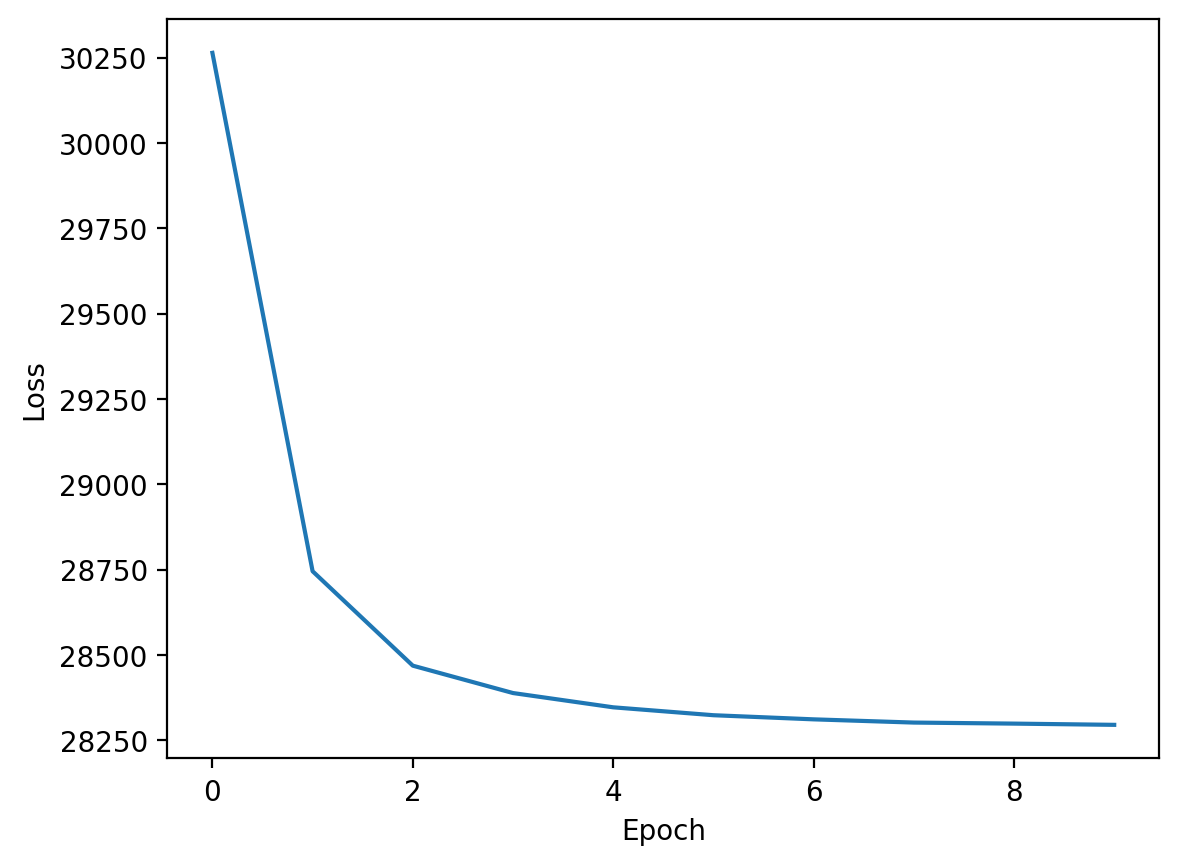

In [ ]:
# График Loss
plt.plot(history_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.manual_seed(45)         #зафиксируем рандом
x_rand = (torch.rand(10,200)*512).to(device)
x_rand.size()

torch.Size([10, 200])

In [ ]:

for i in range(x_rand.size(0)):
  x_r = x_rand[i]  # Извлекаем одну строку тензора
  pict_hat = vae.decoder(x_r).to(device)  # Получим изображение
  save_image(pict_hat.view(3, 128, 128), 'drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№5'+ '_эксперимент_'+ str(i) + '.jpg')  # Сохраним изображение

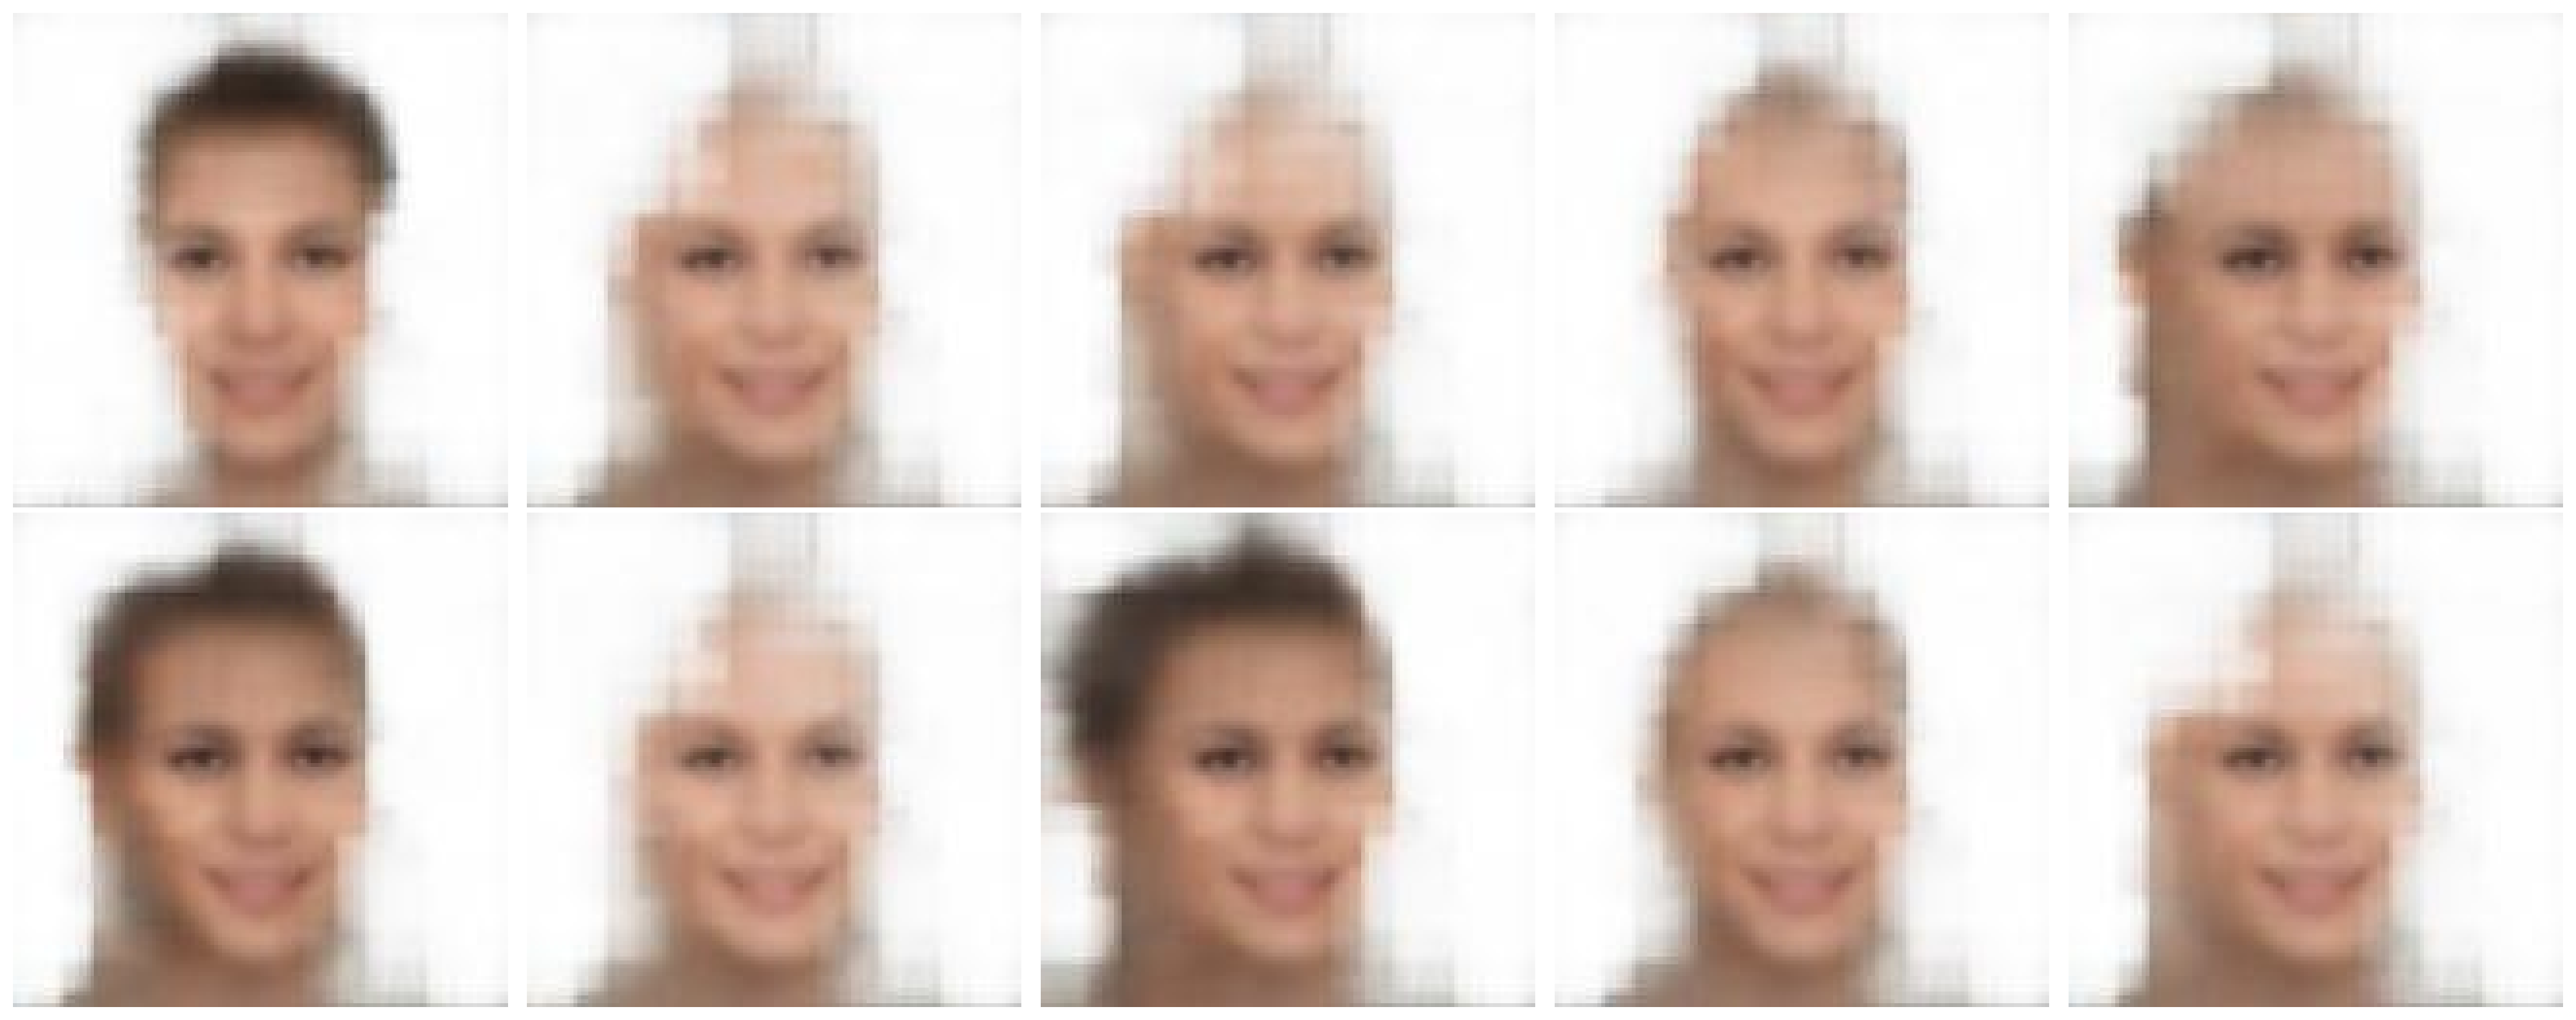

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(10):
  img_1 = Image.open('drive/MyDrive/Colab_Notebooks/SM/SM_1/IMGgenerate/IMGgenerate' + '_Модель_№5'+ '_эксперимент_'+ str(i) + '.jpg')
  axs[i//5, i%5].imshow(img_1)
  axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(vae_5, 'drive/MyDrive/Colab_Notebooks/SM/SM_1/Model/model5.pt')

Итог:
1. Первая модель оказалась луше второй. Добавление нелинейных слоёв не дало лучший эффект.
2. Увеличение вильров сказалось положительно на результате. Можно с уверенностью сказать, что третья модель хоть и училась в 10 раз больше эпох, но качество выше. Хоть третью модель ещё можно ещё немного подучить, так как до конца на плато не вышла.
3. Пятая модель  (добавил 2 нелинейных слоя и увеличел количество фильров, добавил sheduler c gamma=0.5), выучилась за 8 эпох. качество достаточно приличное для такого короткого обучения.